In [8]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nni
import pickle
import json
from pingouin import ancova
from scipy.stats import entropy, linregress, ks_2samp, chisquare
from model import Inputs, build_network, run_once

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', font="CMU Serif", rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [ ]:
def chi_squared_distance(a,b):
    distance = 0
    a = a / np.sum(a)
    b = b / np.sum(b)
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(simulated, empirical):
    # return np.abs(simulated - empirical)
#     print('simulated', simulated, sum(simulated))
#     print('empirical', empirical, sum(empirical))
#     loss = np.sum(np.abs(simulated - empirical))
#     loss = 1 - entropy(simulated, empirical)
    loss = chi_squared_distance(simulated, empirical)
#     print('loss', loss)
    return loss

def run_group(params, deltaPs=[0.1, 0.2, 0.4], name="default"):
    dfs = []
    columns = ('agent', 'pid', 'dP', 'accuracy', 'speed', 'cue loss', 'accuracy loss')
    pids = list(params.keys())
    pids = [int(pid) for pid in pids]
    for pid in pids:
        args = params[pid]
        T = args['T']
        m = args['m']
        tau = args['tau'] if 'tau' in args.keys() else 0
        delta = args['delta'] if 'delta' in args.keys() else 0
        seed = args['seed']
        with open('data/pids.pkl', 'rb') as f:
            studyIDs = pickle.load(f)
        participant_ID = studyIDs[pid]

        for dP in deltaPs:
            print(f"pid={pid}, dP={dP}")
            empirical = pd.read_pickle("data/empirical.pkl").query("maxSamples==12 & delta==@dP & participant_id==@participant_ID")
            empirical_cues = empirical['cues'].to_numpy()
            empirical_accuracy = empirical['correct'].to_numpy()
            empirical_hist = np.histogram(empirical['cues'].to_numpy(), bins=np.arange(0, 27, 3))[0]
            nTrials = empirical.shape[0]
            simulated_cues = []
            simulated_accuracy = []
            inputs = Inputs(deltaP=dP, maxCues=12, seed=pid, empirical=empirical)
            net = build_network(inputs, seed=seed, T=T, m=m, tau=tau, delta=delta)
            for trial in range(nTrials):
                net.inputs.set_AB(trial=trial)
#                 is_correct, cues_sampled = np.random.rand(), int(np.random.uniform(0, 25))
                is_correct, cues_sampled = run_once(net)
#                 print(trial, is_correct, cues_sampled)
                simulated_cues.append(cues_sampled)
                simulated_accuracy.append(1.0*is_correct)
#             print('sim', simulated_cues, len(simulated_cues), 'emp', empirical_cues, len(empirical_cues))
            simulated_hist = np.histogram(simulated_cues, bins=np.arange(0, 27, 3))[0]
            cue_loss = get_loss(simulated_hist, empirical_hist)
            accuracy_loss = np.abs(100*np.mean(simulated_accuracy) - 100*np.mean(empirical_accuracy))
            dfs.append(pd.DataFrame([['model', pid, dP, 100*np.mean(simulated_accuracy), np.mean(simulated_cues), cue_loss, accuracy_loss]], columns=columns))
            dfs.append(pd.DataFrame([['human', pid, dP, 100*np.mean(empirical_accuracy), np.mean(empirical_cues), 0, 0]], columns=columns))

        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/group_behavior_{name}.pkl")
    
def plot_sat_double(name):
    data = pd.read_pickle(f"data/group_behavior_{name}.pkl")

    # fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True, sharey=True)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((7.08, 3.5)), sharex=True, sharey=True)
    sns.regplot(data=data.query("agent=='human' & dP==0.4"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][0])
    sns.regplot(data=data.query("agent=='human' & dP==0.2"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][1])
    sns.regplot(data=data.query("agent=='human' & dP==0.1"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][2])
    sns.regplot(data=data.query("agent=='model' & dP==0.4"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][0])
    sns.regplot(data=data.query("agent=='model' & dP==0.2"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][1])
    sns.regplot(data=data.query("agent=='model' & dP==0.1"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][2])
    # sns.regplot(data=sat_data.query("agent=='human' & dP==0.4"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[2], ax=axes[0])
    # sns.regplot(data=sat_data.query("agent=='human' & dP==0.2"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[0], ax=axes[1])
    # sns.regplot(data=sat_data.query("agent=='human' & dP==0.1"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[1], ax=axes[2])
    sns.scatterplot(x=[0],y=[0], color=palette[0], label=f"Human Data", ax=axes[0][0])
    sns.scatterplot(x=[0],y=[0], color=palette[1], label=f"Model Data", ax=axes[1][0])
    axes[0][0].set(ylabel='Mean Accuracy', xlabel=None, title="Easy", ylim=((40, 110)), yticks=np.arange(40, 110, 10))
    axes[0][1].set(ylabel=None, xlabel=None, title="Moderate")
    axes[0][2].set(ylabel=None, xlabel=None, title="Hard", xticks=np.arange(0, 27, 3), xlim=((-1, 25)))
    axes[1][0].set(ylabel='Mean Accuracy', xlabel='Mean Cues', ylim=((40, 110)), yticks=np.arange(40, 110, 10))
    axes[1][1].set(ylabel=None, xlabel='Mean Cues')
    axes[1][2].set(ylabel=None, xlabel='Mean Cues', xticks=np.arange(0, 27, 3), xlim=((-1, 25)))
    axes[0][0].legend(loc='lower right')
    axes[1][0].legend(loc='lower right')
    plt.tight_layout()
    fig.savefig(f"plots/group_behavior_{name}.svg")
    fig.savefig(f"plots/group_behavior_{name}.png", dpi=600)
    
def plot_sat_single(name):
    data = pd.read_pickle(f"data/group_behavior_{name}.pkl")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((7.08, 3)), sharex=True, sharey=True)
    sns.regplot(data=data.query("agent=='human' & dP==0.4"), x='speed', y='accuracy', scatter=False, line_kws={'color': palette[0]}, ax=axes[0])
    sns.regplot(data=data.query("agent=='human' & dP==0.2"), x='speed', y='accuracy', scatter=False, line_kws={'color': palette[0]}, ax=axes[1])
    sns.regplot(data=data.query("agent=='human' & dP==0.1"), x='speed', y='accuracy', scatter=False, line_kws={'color': palette[0]}, ax=axes[2])
    sns.regplot(data=data.query("agent=='model' & dP==0.4"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[0])
    sns.regplot(data=data.query("agent=='model' & dP==0.2"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1])
    sns.regplot(data=data.query("agent=='model' & dP==0.1"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[2])
    sns.scatterplot(x=[0],y=[0], color=palette[0], label=f"Human Data", ax=axes[0])
    sns.scatterplot(x=[0],y=[0], color=palette[1], label=f"Model Data", ax=axes[0])
    axes[0].set(ylabel='Mean Accuracy', xlabel='Mean Cues', title="Easy", ylim=((50, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1].set(xlabel='Mean Cues', ylabel=None, title="Moderate")
    axes[2].set(xlabel='Mean Cues', ylabel=None, title="Hard", xticks=np.arange(0, 27, 3), xlim=((0, 24)))
    axes[0].legend(loc='lower right')
    plt.tight_layout()
    fig.savefig(f"plots/group_behavior_{name}.svg")
    fig.savefig(f"plots/group_behavior_{name}.png", dpi=600)
    
def plot_loss(name):
    data = pd.read_pickle(f"data/group_behavior_{name}.pkl")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((7.08, 2)), sharex=False, sharey=True)
    sns.histplot(data=data.query("dP==0.4 & agent=='model'"), x='cue loss', bins=np.arange(0, 1.1, 0.1),
        color=palette[1], ax=axes[0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='model'"), x='cue loss', bins=np.arange(0, 1.1, 0.1),
        color=palette[1], ax=axes[1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='model'"), x='cue loss', bins=np.arange(0, 1.1, 0.1),
        color=palette[1], ax=axes[2], stat='percent', multiple='layer', element='step', linewidth=1)
    axes[0].set(xticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)), title="Easy", ylabel="Frequency (%)", xlabel="Cue Loss ($\Delta$ cues)")
    axes[1].set(xticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)), title="Moderate", xlabel="Cue Loss ($\Delta$ cues)")
    axes[2].set(xticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)), title="Hard", xlabel="Cue Loss ($\Delta$ cues)")
    plt.tight_layout()
    fig.savefig(f"plots/cue_loss_{name}.svg")
    fig.savefig(f"plots/cue_loss_{name}.png", dpi=600)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((7.08, 2)), sharex=False, sharey=True)
    sns.histplot(data=data.query("dP==0.4 & agent=='model'"), x='accuracy loss', bins=np.arange(0, 23, 3),
        color=palette[1], ax=axes[0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='model'"), x='accuracy loss', bins=np.arange(0, 23, 3),
        color=palette[1], ax=axes[1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='model'"), x='accuracy loss', bins=np.arange(0, 23, 3),
        color=palette[1], ax=axes[2], stat='percent', multiple='layer', element='step', linewidth=1)
    axes[0].set(xticks=((0,5,10,15,20)), ylabel="Frequency (%)", xlabel="Accuracy Loss ($\Delta$%)")
    axes[1].set(xticks=((0,5,10,15,20)), xlabel="Accuracy Loss ($\Delta$%)")
    axes[2].set(xticks=((0,5,10,15,20)), xlabel="Accuracy Loss ($\Delta$%)")
    plt.tight_layout()
    fig.savefig(f"plots/accuracy_loss_{name}.svg")
    fig.savefig(f"plots/accuracy_loss_{name}.png", dpi=600)

In [4]:
def plot_empirical(name):
    data = pd.read_pickle(f"data/group_behavior_{name}.pkl")
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=((7.08, 6)), sharex=False, sharey=False)
    speed_bins = np.arange(0,27,3)
    accuracy_bins = np.arange(50, 105, 5)

    sns.regplot(data=data.query("agent=='human' & dP==0.4"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][0])
    sns.regplot(data=data.query("agent=='human' & dP==0.2"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][1])
    sns.regplot(data=data.query("agent=='human' & dP==0.1"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][2])
    axes[0][0].set(ylabel='Mean Accuracy', xlabel='Mean Cues', title="Easy")
    axes[0][1].set(xlabel='Mean Cues', ylabel=None, title="Moderate")
    axes[0][2].set(xlabel='Mean Cues', ylabel=None, title="Hard")

    sns.histplot(data=data.query("dP==0.4 & agent=='human'"), x='speed', bins=speed_bins,
        color=palette[0], ax=axes[1][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='human'"), x='speed', bins=speed_bins,
        color=palette[0], ax=axes[1][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='human'"), x='speed', bins=speed_bins,
        color=palette[0], ax=axes[1][2], stat='percent', multiple='layer', element='step', linewidth=1)
    axes[1][0].set(ylabel="Frequency (%)", xlabel="Mean Cues")
    axes[1][1].set(ylabel=None, xlabel="Mean Cues")
    axes[1][2].set(ylabel=None, xlabel="Mean Cues")
    
    sns.histplot(data=data.query("dP==0.4 & agent=='human'"), x='accuracy', bins=accuracy_bins,
        color=palette[0], ax=axes[2][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='human'"), x='accuracy', bins=accuracy_bins,
        color=palette[0], ax=axes[2][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='human'"), x='accuracy', bins=accuracy_bins,
        color=palette[0], ax=axes[2][2], stat='percent', multiple='layer', element='step', linewidth=1)
    axes[2][0].set(ylabel="Frequency (%)", xlabel="Mean Accuracy")
    axes[2][1].set(ylabel=None, xlabel="Mean Accuracy")
    axes[2][2].set(ylabel=None, xlabel="Mean Accuracy")
    
    plt.tight_layout()
    fig.savefig(f"plots/empirical_speed_and_accuracy.svg")
    fig.savefig(f"plots/empirical_speed_and_accuracy.png", dpi=600)

In [53]:
def normalize(array):
    return array / np.sum(array)

In [97]:
def plot_speed_and_accuracy(name):
    data = pd.read_pickle(f"data/group_behavior_{name}.pkl")
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=((7.08, 6)), sharex=False, sharey=False)
    speed_bins = np.arange(0,27,3)
    accuracy_bins = np.arange(40, 110, 10)

    sns.regplot(data=data.query("agent=='human' & dP==0.4"), x='speed', y='accuracy', scatter=False, line_kws={'color': palette[0]}, ax=axes[0][0])
    sns.regplot(data=data.query("agent=='human' & dP==0.2"), x='speed', y='accuracy', scatter=False, line_kws={'color': palette[0]}, ax=axes[0][1])
    sns.regplot(data=data.query("agent=='human' & dP==0.1"), x='speed', y='accuracy', scatter=False, line_kws={'color': palette[0]}, ax=axes[0][2])
    sns.regplot(data=data.query("agent=='model' & dP==0.4"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[0][0])
    sns.regplot(data=data.query("agent=='model' & dP==0.2"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[0][1])
    sns.regplot(data=data.query("agent=='model' & dP==0.1"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[0][2])
    sns.scatterplot(x=[0],y=[0], color=palette[0], label=f"Human Data", ax=axes[0][0])
    sns.scatterplot(x=[0],y=[0], color=palette[1], label=f"Model Data", ax=axes[0][0])
    axes[0][0].set(ylabel='Mean Accuracy', xlabel='Mean Cues', title="Easy", ylim=((40, 110)), yticks=accuracy_bins, xticks=speed_bins)
    axes[0][1].set(xlabel='Mean Cues', ylabel=None, title="Moderate", ylim=((40, 110)), yticks=accuracy_bins, xticks=speed_bins)
    axes[0][2].set(xlabel='Mean Cues', ylabel=None, title="Hard", ylim=((40, 110)), yticks=accuracy_bins, xticks=speed_bins)
    axes[0][0].legend(loc='lower right')

#     ks_speed_easy = ks_2samp(
#         data.query("dP==0.4 & agent=='human'")['speed'].to_numpy(),
#         data.query("dP==0.4 & agent=='model'")['speed'].to_numpy())
#     ks_speed_moderate = ks_2samp(
#         data.query("dP==0.2 & agent=='human'")['speed'].to_numpy(),
#         data.query("dP==0.2 & agent=='model'")['speed'].to_numpy())
#     ks_speed_hard = ks_2samp(
#         data.query("dP==0.1 & agent=='human'")['speed'].to_numpy(),
#         data.query("dP==0.1 & agent=='model'")['speed'].to_numpy())
#     entropy_speed_easy = entropy(
#         np.histogram(data.query("dP==0.4 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0],
#         np.histogram(data.query("dP==0.4 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
#     entropy_speed_moderate = entropy(
#         np.histogram(data.query("dP==0.2 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0],
#         np.histogram(data.query("dP==0.2 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
#     entropy_speed_hard = entropy(
#         np.histogram(data.query("dP==0.1 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0],
#         np.histogram(data.query("dP==0.1 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
#     hist_speed_easy_human = normalize(np.histogram(data.query("dP==0.4 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0])
#     hist_speed_easy_model = normalize(np.histogram(data.query("dP==0.4 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
#     hist_speed_moderate_human = normalize(np.histogram(data.query("dP==0.2 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0])
#     hist_speed_moderate_model = normalize(np.histogram(data.query("dP==0.2 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
#     hist_speed_hard_human = normalize(np.histogram(data.query("dP==0.1 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0])
#     hist_speed_hard_model = normalize(np.histogram(data.query("dP==0.1 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
#     chisquared_speed_easy = chisquare(hist_speed_easy_model, hist_speed_easy_human)
#     chisquared_speed_moderate = chisquare(hist_speed_moderate_model, hist_speed_moderate_human)
#     chisquared_speed_hard = chisquare(hist_speed_hard_model, hist_speed_hard_human)
    chisquared_speed_easy = chi_squared_distance(
        np.histogram(data.query("dP==0.4 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0],
        np.histogram(data.query("dP==0.4 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
    chisquared_speed_moderate = chi_squared_distance(
        np.histogram(data.query("dP==0.2 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0],
        np.histogram(data.query("dP==0.2 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
    chisquared_speed_hard = chi_squared_distance(
        np.histogram(data.query("dP==0.1 & agent=='human'")['speed'].to_numpy(), bins=speed_bins)[0],
        np.histogram(data.query("dP==0.1 & agent=='model'")['speed'].to_numpy(), bins=speed_bins)[0])
    
    sns.histplot(data=data.query("dP==0.4 & agent=='human'"), x='speed', bins=speed_bins,
        color=palette[0], ax=axes[1][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='human'"), x='speed', bins=speed_bins,
        color=palette[0], ax=axes[1][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='human'"), x='speed', bins=speed_bins,
        color=palette[0], ax=axes[1][2], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.4 & agent=='model'"), x='speed', bins=speed_bins,
        color=palette[1], ax=axes[1][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='model'"), x='speed', bins=speed_bins,
        color=palette[1], ax=axes[1][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='model'"), x='speed', bins=speed_bins,
        color=palette[1], ax=axes[1][2], stat='percent', multiple='layer', element='step', linewidth=1)
#     axes[1][0].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel="Frequency (%)", xlabel="Mean Cues",
# #             title=f"max CDF difference={ks_speed_easy.statistic:.3}\ndifferent distribution: p={ks_speed_easy.pvalue:.3}")
#             title=f"KS Statistic: d={ks_speed_easy.statistic:.3}\nKS Significance: p={ks_speed_easy.pvalue:.3}")
#     axes[1][1].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel=None, xlabel="Mean Cues",
# #             title=f"max CDF difference={ks_speed_moderate.statistic:.3}\ndifferent distribution: p={ks_speed_moderate.pvalue:.3}")
#             title=f"KS Statistic: d={ks_speed_moderate.statistic:.3}\nKS Significance: p={ks_speed_moderate.pvalue:.3}")
#     axes[1][2].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel=None, xlabel="Mean Cues",
# #             title=f"max CDF difference={ks_speed_hard.statistic:.3}\ndifferent distribution: p={ks_speed_hard.pvalue:.3}")
#             title=f"KS Statistic: d={ks_speed_hard.statistic:.3}\nKS Significance: p={ks_speed_hard.pvalue:.3}")
#     axes[1][0].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel="Frequency (%)", xlabel="Mean Cues",
#             title=f"similarity={entropy_speed_easy:.3}")
#     axes[1][1].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel=None, xlabel="Mean Cues",
#             title=f"similarity={entropy_speed_moderate:.3}")
#     axes[1][2].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel=None, xlabel="Mean Cues",
#             title=f"similarity={entropy_speed_hard:.3}")
    axes[1][0].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel="Frequency (%)", xlabel="Mean Cues",
#             title=f"Chi Squared Test:\n x={chisquared_speed_easy.statistic:.3}, p={chisquared_speed_easy.pvalue:.3}")
            title=r"$\chi^2=$ " + f"{chisquared_speed_easy:.3}")
    axes[1][1].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel=None, xlabel="Mean Cues",
#             title=f"Chi Squared Test:\n x={chisquared_speed_moderate.statistic:.3}, p={chisquared_speed_moderate.pvalue:.3}")
            title=r"$\chi^2=$ " + f"{chisquared_speed_moderate:.3}")
    axes[1][2].set(xticks=speed_bins, yticks=np.arange(0,40,5), ylabel=None, xlabel="Mean Cues",
#             title=f"Chi Squared Test:\n x={chisquared_speed_hard.statistic:.3}, p={chisquared_speed_hard.pvalue:.3}")
            title=r"$\chi^2=$ " + f"{chisquared_speed_hard:.3}")
    
#     ks_accuracy_easy = ks_2samp(
#         data.query("dP==0.4 & agent=='human'")['accuracy'].to_numpy(),
#         data.query("dP==0.4 & agent=='model'")['accuracy'].to_numpy())
#     ks_accuracy_moderate = ks_2samp(
#         data.query("dP==0.2 & agent=='human'")['accuracy'].to_numpy(),
#         data.query("dP==0.2 & agent=='model'")['accuracy'].to_numpy())
#     ks_accuracy_hard = ks_2samp(
#         data.query("dP==0.1 & agent=='human'")['accuracy'].to_numpy(),
#         data.query("dP==0.1 & agent=='model'")['accuracy'].to_numpy())
#     entropy_accuracy_easy = entropy(
#         np.histogram(data.query("dP==0.4 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0],
#         np.histogram(data.query("dP==0.4 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     entropy_accuracy_moderate = entropy(
#         np.histogram(data.query("dP==0.2 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0],
#         np.histogram(data.query("dP==0.2 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     entropy_accuracy_hard = entropy(
#         np.histogram(data.query("dP==0.1 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0],
#         np.histogram(data.query("dP==0.1 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     hist_accuracy_easy_human = normalize(np.histogram(data.query("dP==0.4 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     hist_accuracy_easy_model = normalize(np.histogram(data.query("dP==0.4 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     hist_accuracy_moderate_human = normalize(np.histogram(data.query("dP==0.2 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     hist_accuracy_moderate_model = normalize(np.histogram(data.query("dP==0.2 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     hist_accuracy_hard_human = normalize(np.histogram(data.query("dP==0.1 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     hist_accuracy_hard_model = normalize(np.histogram(data.query("dP==0.1 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
#     chisquared_accuracy_easy = chisquare(hist_accuracy_easy_model, hist_accuracy_easy_human)
#     chisquared_accuracy_moderate = chisquare(hist_accuracy_moderate_model, hist_accuracy_moderate_human)
#     chisquared_accuracy_hard = chisquare(hist_accuracy_hard_model, hist_accuracy_hard_human)
    chisquared_accuracy_easy = chi_squared_distance(
        np.histogram(data.query("dP==0.4 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0],
        np.histogram(data.query("dP==0.4 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
    chisquared_accuracy_moderate = chi_squared_distance(
        np.histogram(data.query("dP==0.2 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0],
        np.histogram(data.query("dP==0.2 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])
    chisquared_accuracy_hard = chi_squared_distance(
        np.histogram(data.query("dP==0.1 & agent=='human'")['accuracy'].to_numpy(), bins=accuracy_bins)[0],
        np.histogram(data.query("dP==0.1 & agent=='model'")['accuracy'].to_numpy(), bins=accuracy_bins)[0])


    sns.histplot(data=data.query("dP==0.4 & agent=='human'"), x='accuracy', bins=accuracy_bins,
        color=palette[0], ax=axes[2][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='human'"), x='accuracy', bins=accuracy_bins,
        color=palette[0], ax=axes[2][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='human'"), x='accuracy', bins=accuracy_bins,
        color=palette[0], ax=axes[2][2], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.4 & agent=='model'"), x='accuracy', bins=accuracy_bins,
        color=palette[1], ax=axes[2][0], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.2 & agent=='model'"), x='accuracy', bins=accuracy_bins,
        color=palette[1], ax=axes[2][1], stat='percent', multiple='layer', element='step', linewidth=1)
    sns.histplot(data=data.query("dP==0.1 & agent=='model'"), x='accuracy', bins=accuracy_bins,
        color=palette[1], ax=axes[2][2], stat='percent', multiple='layer', element='step', linewidth=1)
#     axes[2][0].set(xticks=accuracy_bins, ylabel="Frequency (%)", xlabel="Mean Accuracy",
#             title=f"KS Statistic: d={ks_accuracy_easy.statistic:.3}\nKS Significance: p={ks_accuracy_easy.pvalue:.3}")
#     axes[2][1].set(xticks=accuracy_bins, ylabel=None, xlabel="Mean Accuracy",
#             title=f"KS Statistic: d={ks_accuracy_moderate.statistic:.3}\nKS Significance: p={ks_accuracy_moderate.pvalue:.3}")
#     axes[2][2].set(xticks=accuracy_bins, ylabel=None, xlabel="Mean Accuracy",   
#             title=f"KS Statistic: d={ks_accuracy_hard.statistic:.3}\nKS Significance: p={ks_accuracy_hard.pvalue:.3}")
#     axes[2][0].set(xticks=accuracy_bins, yticks=np.arange(0,100,20), ylabel="Frequency (%)", xlabel="Mean Accuracy",
#             title=f"similarity={entropy_accuracy_easy:.3}")
#     axes[2][1].set(xticks=accuracy_bins, yticks=np.arange(0,100,20), ylabel=None, xlabel="Mean Accuracy",
#             title=f"similarity={entropy_accuracy_moderate:.3}")
#     axes[2][2].set(xticks=accuracy_bins, yticks=np.arange(0,100,20), ylabel=None, xlabel="Mean Accuracy",   
#             title=f"similarity={entropy_accuracy_hard:.3}")
    axes[2][0].set(xticks=accuracy_bins, yticks=np.arange(0,100,20), ylabel="Frequency (%)", xlabel="Mean Accuracy",
#             title=f"Chi Squared Test:\n x={chisquared_accuracy_easy.statistic:.3}, p={chisquared_accuracy_easy.pvalue:.3}")
            title=r"$\chi^2=$ " + f"{chisquared_accuracy_easy:.3}")
    axes[2][1].set(xticks=accuracy_bins, yticks=np.arange(0,100,20), ylabel=None, xlabel="Mean Accuracy",
#             title=f"Chi Squared Test:\n x={chisquared_accuracy_moderate.statistic:.3}, p={chisquared_accuracy_moderate.pvalue:.3}")
            title=r"$\chi^2=$ " + f"{chisquared_accuracy_moderate:.3}")
    axes[2][2].set(xticks=accuracy_bins, yticks=np.arange(0,100,20), ylabel=None, xlabel="Mean Accuracy",
#             title=f"Chi Squared Test:\n x={chisquared_accuracy_hard.statistic:.3}, p={chisquared_accuracy_hard.pvalue:.3}")
            title=r"$\chi^2=$ " + f"{chisquared_accuracy_hard:.3}")
    
    plt.tight_layout()
    fig.savefig(f"plots/speed_and_accuracy_{name}.svg")
    fig.savefig(f"plots/speed_and_accuracy_{name}.png", dpi=600)

In [98]:
def test_sat(name):
    data = pd.read_pickle(f"data/group_behavior_{name}.pkl")
    print("easy")
    print(ancova(data=data.query("dP==0.4"), dv='accuracy', covar='speed', between='agent'))
    x = data.query("dP==0.4 & agent=='human'")['speed'].to_numpy()
    y = data.query("dP==0.4 & agent=='human'")['accuracy'].to_numpy()
    res_human = linregress(x, y)
    x2 = data.query("dP==0.4 & agent=='model'")['speed'].to_numpy()
    y2 = data.query("dP==0.4 & agent=='model'")['accuracy'].to_numpy()
    res_agent = linregress(x2, y2)
    print("human", res_human)
    print("agent", res_agent)
    
    print("moderate")
    print(ancova(data=data.query("dP==0.2"), dv='accuracy', covar='speed', between='agent'))
    x = data.query("dP==0.2 & agent=='human'")['speed'].to_numpy()
    y = data.query("dP==0.2 & agent=='human'")['accuracy'].to_numpy()
    res_human = linregress(x, y)
    x2 = data.query("dP==0.2 & agent=='model'")['speed'].to_numpy()
    y2 = data.query("dP==0.2 & agent=='model'")['accuracy'].to_numpy()
    res_agent = linregress(x2, y2)
    print("human", res_human)
    print("agent", res_agent)
    
    print("difficult")
    print(ancova(data=data.query("dP==0.1"), dv='accuracy', covar='speed', between='agent'))
    x = data.query("dP==0.1 & agent=='human'")['speed'].to_numpy()
    y = data.query("dP==0.1 & agent=='human'")['accuracy'].to_numpy()
    res_human = linregress(x, y)
    x2 = data.query("dP==0.1 & agent=='model'")['speed'].to_numpy()
    y2 = data.query("dP==0.1 & agent=='model'")['accuracy'].to_numpy()
    res_agent = linregress(x2, y2)
    print("human", res_human)
    print("agent", res_agent)

In [99]:
# plot_empirical("tm2")

## T, m

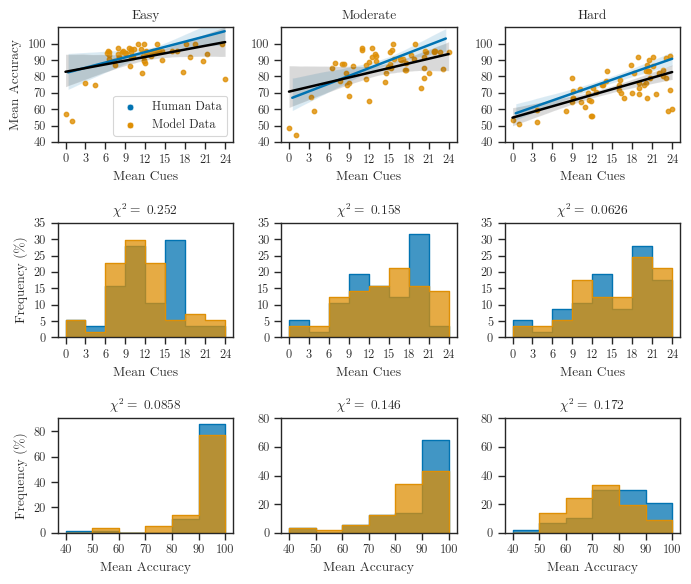

In [100]:
name = "tm2"
params = {0: {'m': 0.16, 'seed': 31, 'T': 0.68}, 1: {'m': 0.43, 'seed': 67, 'T': 0.4}, 2: {'m': 0.87, 'seed': 61, 'T': 0.8300000000000001}, 3: {'m': 0.0, 'seed': 6, 'T': 0.65}, 4: {'m': 0.22, 'seed': 90, 'T': 0.41000000000000003}, 5: {'m': 0.47000000000000003, 'seed': 86, 'T': 0.44}, 6: {'m': 0.97, 'seed': 16, 'T': 0.93}, 7: {'m': 0.53, 'seed': 67, 'T': 0.02}, 8: {'m': 0.35000000000000003, 'seed': 32, 'T': 0.51}, 9: {'m': 0.15, 'seed': 43, 'T': 0.42}, 10: {'m': 0.66, 'seed': 76, 'T': 0.9500000000000001}, 11: {'m': 0.9500000000000001, 'seed': 15, 'T': 0.8200000000000001}, 12: {'m': 0.26, 'seed': 1, 'T': 0.52}, 13: {'m': 0.33, 'seed': 40, 'T': 0.13}, 14: {'m': 0.27, 'seed': 31, 'T': 0.51}, 15: {'m': 0.13, 'seed': 76, 'T': 0.51}, 16: {'m': 0.12, 'seed': 22, 'T': 0.27}, 17: {'m': 0.25, 'seed': 2, 'T': 0.24}, 18: {'m': 0.13, 'seed': 14, 'T': 0.13}, 19: {'m': 0.31, 'seed': 48, 'T': 0.58}, 20: {'m': 0.37, 'seed': 54, 'T': 0.73}, 21: {'m': 0.31, 'seed': 43, 'T': 0.28}, 22: {'m': 0.58, 'seed': 88, 'T': 0.5700000000000001}, 23: {'m': 0.14, 'seed': 65, 'T': 0.26}, 24: {'m': 0.16, 'seed': 17, 'T': 0.33}, 25: {'m': 0.15, 'seed': 85, 'T': 0.07}, 26: {'m': 0.03, 'seed': 8, 'T': 0.02}, 27: {'m': 0.48, 'seed': 47, 'T': 0.9400000000000001}, 28: {'m': 0.25, 'seed': 29, 'T': 0.61}, 29: {'m': 0.04, 'seed': 47, 'T': 0.13}, 30: {'m': 0.5, 'seed': 1, 'T': 1.0}, 31: {'m': 0.11, 'seed': 24, 'T': 0.61}, 32: {'m': 0.59, 'seed': 72, 'T': 0.58}, 33: {'m': 0.13, 'seed': 46, 'T': 0.18}, 34: {'m': 0.31, 'seed': 43, 'T': 0.6}, 35: {'m': 0.39, 'seed': 25, 'T': 0.96}, 36: {'m': 0.05, 'seed': 45, 'T': 0.08}, 37: {'m': 0.22, 'seed': 58, 'T': 0.72}, 38: {'m': 0.07, 'seed': 52, 'T': 0.12}, 39: {'m': 0.53, 'seed': 73, 'T': 0.62}, 40: {'m': 0.36, 'seed': 68, 'T': 0.7000000000000001}, 41: {'m': 0.62, 'seed': 11, 'T': 0.6}, 42: {'m': 0.47000000000000003, 'seed': 98, 'T': 0.9400000000000001}, 43: {'m': 0.25, 'seed': 84, 'T': 0.61}, 44: {'m': 0.27, 'seed': 11, 'T': 0.63}, 45: {'m': 0.34, 'seed': 43, 'T': 0.49}, 46: {'m': 0.33, 'seed': 95, 'T': 0.47000000000000003}, 47: {'m': 0.35000000000000003, 'seed': 13, 'T': 0.84}, 48: {'m': 0.19, 'seed': 2, 'T': 0.44}, 49: {'m': 0.13, 'seed': 42, 'T': 0.29}, 50: {'m': 0.51, 'seed': 58, 'T': 0.98}, 51: {'m': 0.6, 'seed': 37, 'T': 0.92}, 52: {'m': 0.29, 'seed': 53, 'T': 0.27}, 53: {'m': 0.16, 'seed': 12, 'T': 0.23}, 54: {'m': 0.1, 'seed': 52, 'T': 0.29}, 55: {'m': 0.02, 'seed': 33, 'T': 0.04}, 56: {'m': 0.54, 'seed': 10, 'T': 0.98}}
# run_group(params, name=name)
plot_speed_and_accuracy(name)

## T, m, tau

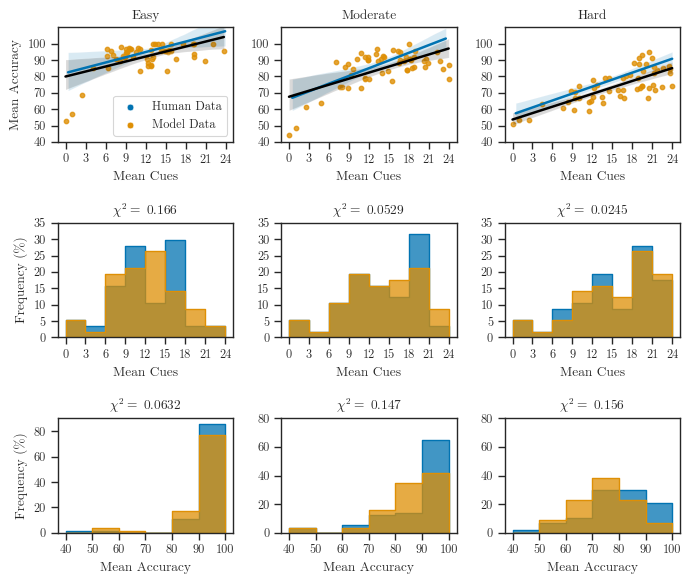

In [101]:
name = "T_m_tau"
params = {0: {'m': 0.1, 'seed': 88, 'T': 0.66, 'tau': 0.03}, 1: {'m': 0.52, 'seed': 92, 'T': 0.85, 'tau': 0.07}, 2: {'m': 0.2, 'seed': 41, 'T': 0.39, 'tau': 0.04}, 3: {'m': 0.11, 'seed': 92, 'T': 0.88, 'tau': 0.04}, 4: {'m': 0.41000000000000003, 'seed': 6, 'T': 0.9400000000000001, 'tau': 0.05}, 5: {'m': 0.67, 'seed': 96, 'T': 1.0, 'tau': 0.11}, 6: {'m': 0.39, 'seed': 93, 'T': 0.89, 'tau': 0.05}, 7: {'m': 0.34, 'seed': 22, 'T': 0.5, 'tau': 0.8300000000000001}, 8: {'m': 0.47000000000000003, 'seed': 6, 'T': 0.88, 'tau': 0.05}, 9: {'m': 0.23, 'seed': 92, 'T': 1.0, 'tau': 0.06}, 10: {'m': 0.34, 'seed': 25, 'T': 0.8200000000000001, 'tau': 0.07}, 11: {'m': 0.73, 'seed': 3, 'T': 0.93, 'tau': 0.07}, 12: {'m': 0.23, 'seed': 22, 'T': 0.92, 'tau': 0.06}, 13: {'m': 0.5700000000000001, 'seed': 99, 'T': 0.05, 'tau': 0.38}, 14: {'m': 0.09, 'seed': 3, 'T': 0.8300000000000001, 'tau': 0.07}, 15: {'m': 0.08, 'seed': 23, 'T': 0.47000000000000003, 'tau': 0.02}, 16: {'m': 0.08, 'seed': 54, 'T': 0.96, 'tau': 0.08}, 17: {'m': 0.65, 'seed': 11, 'T': 0.73, 'tau': 0.04}, 18: {'m': 0.34, 'seed': 11, 'T': 0.93, 'tau': 0.1}, 19: {'m': 0.38, 'seed': 85, 'T': 0.72, 'tau': 0.0}, 20: {'m': 0.16, 'seed': 82, 'T': 0.86, 'tau': 0.07}, 21: {'m': 0.61, 'seed': 40, 'T': 0.88, 'tau': 0.1}, 22: {'m': 0.26, 'seed': 27, 'T': 0.71, 'tau': 0.08}, 23: {'m': 0.25, 'seed': 41, 'T': 0.86, 'tau': 0.07}, 24: {'m': 0.11, 'seed': 85, 'T': 0.72, 'tau': 0.06}, 25: {'m': 0.1, 'seed': 13, 'T': 0.63, 'tau': 0.42}, 26: {'m': 0.9, 'seed': 80, 'T': 0.8200000000000001, 'tau': 0.16}, 27: {'m': 0.16, 'seed': 74, 'T': 0.9500000000000001, 'tau': 0.06}, 28: {'m': 0.31, 'seed': 78, 'T': 0.8, 'tau': 0.01}, 29: {'m': 0.09, 'seed': 82, 'T': 0.87, 'tau': 0.06}, 30: {'m': 0.37, 'seed': 42, 'T': 0.98, 'tau': 0.05}, 31: {'m': 0.05, 'seed': 14, 'T': 0.93, 'tau': 0.08}, 32: {'m': 0.27, 'seed': 34, 'T': 0.56, 'tau': 0.03}, 33: {'m': 0.39, 'seed': 53, 'T': 0.92, 'tau': 0.1}, 34: {'m': 0.29, 'seed': 87, 'T': 0.99, 'tau': 0.06}, 35: {'m': 0.23, 'seed': 8, 'T': 0.7000000000000001, 'tau': 0.02}, 36: {'m': 0.29, 'seed': 85, 'T': 0.88, 'tau': 0.06}, 37: {'m': 0.2, 'seed': 45, 'T': 0.8, 'tau': 0.02}, 38: {'m': 0.25, 'seed': 53, 'T': 0.85, 'tau': 0.06}, 39: {'m': 0.46, 'seed': 5, 'T': 0.73, 'tau': 0.02}, 40: {'m': 0.35000000000000003, 'seed': 42, 'T': 0.67, 'tau': 0.0}, 41: {'m': 0.49, 'seed': 74, 'T': 1.0, 'tau': 0.07}, 42: {'m': 0.24, 'seed': 59, 'T': 0.84, 'tau': 0.04}, 43: {'m': 0.19, 'seed': 6, 'T': 0.88, 'tau': 0.06}, 44: {'m': 0.3, 'seed': 16, 'T': 0.85, 'tau': 0.02}, 45: {'m': 0.38, 'seed': 92, 'T': 0.87, 'tau': 0.08}, 46: {'m': 0.47000000000000003, 'seed': 69, 'T': 0.96, 'tau': 0.07}, 47: {'m': 0.2, 'seed': 27, 'T': 1.0, 'tau': 0.08}, 48: {'m': 0.16, 'seed': 83, 'T': 0.9400000000000001, 'tau': 0.07}, 49: {'m': 0.28, 'seed': 23, 'T': 0.73, 'tau': 0.02}, 50: {'m': 0.24, 'seed': 28, 'T': 0.93, 'tau': 0.05}, 51: {'m': 0.52, 'seed': 98, 'T': 0.9, 'tau': 0.02}, 52: {'m': 1.0, 'seed': 92, 'T': 0.91, 'tau': 0.0}, 53: {'m': 0.45, 'seed': 33, 'T': 0.98, 'tau': 0.05}, 54: {'m': 0.07, 'seed': 40, 'T': 0.73, 'tau': 0.03}, 55: {'m': 0.39, 'seed': 55, 'T': 0.98, 'tau': 0.08}, 56: {'m': 0.3, 'seed': 94, 'T': 0.98, 'tau': 0.04}}
# run_group(params, name=name)
plot_speed_and_accuracy(name)

## T, m, delta

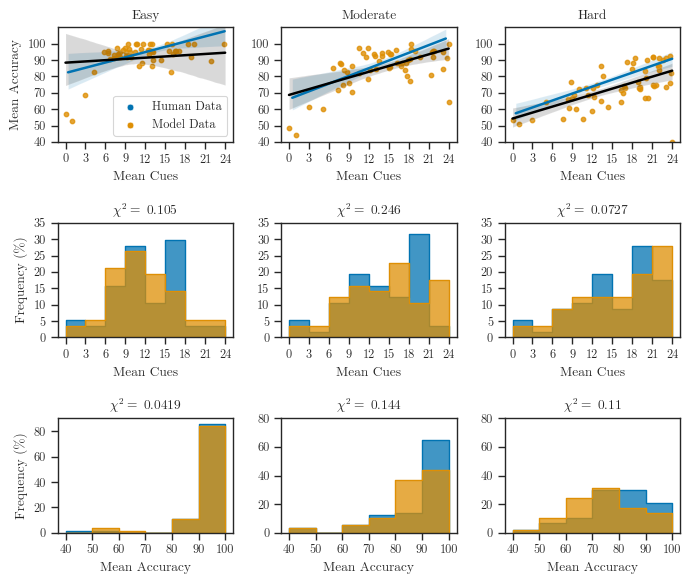

In [102]:
name = "T_m_delta"
params = {0: {'delta': 0.25, 'm': 0.16, 'seed': 11, 'T': 0.84}, 1: {'delta': 0.5, 'm': 0.33, 'seed': 5, 'T': 0.46}, 2: {'delta': 0.97, 'm': 0.2, 'seed': 88, 'T': 0.37}, 3: {'delta': 0.9, 'm': 0.02, 'seed': 88, 'T': 0.61}, 4: {'delta': 0.06, 'm': 0.2, 'seed': 80, 'T': 0.39}, 5: {'delta': 0.56, 'm': 0.04, 'seed': 70, 'T': 0.09}, 6: {'delta': 0.05, 'm': 0.96, 'seed': 92, 'T': 0.96}, 7: {'delta': 0.72, 'm': 0.84, 'seed': 32, 'T': 0.26}, 8: {'delta': 0.27, 'm': 0.35000000000000003, 'seed': 23, 'T': 0.62}, 9: {'delta': 0.38, 'm': 0.27, 'seed': 17, 'T': 0.93}, 10: {'delta': 0.8300000000000001, 'm': 0.12, 'seed': 52, 'T': 0.31}, 11: {'delta': 0.52, 'm': 0.66, 'seed': 22, 'T': 0.93}, 12: {'delta': 0.7000000000000001, 'm': 0.26, 'seed': 4, 'T': 0.89}, 13: {'delta': 0.75, 'm': 0.52, 'seed': 46, 'T': 0.39}, 14: {'delta': 0.37, 'm': 0.29, 'seed': 98, 'T': 0.77}, 15: {'delta': 0.42, 'm': 0.14, 'seed': 85, 'T': 0.9}, 16: {'delta': 0.87, 'm': 0.08, 'seed': 37, 'T': 0.41000000000000003}, 17: {'delta': 0.97, 'm': 0.38, 'seed': 76, 'T': 0.6900000000000001}, 18: {'delta': 0.99, 'm': 0.29, 'seed': 16, 'T': 0.55}, 19: {'delta': 0.35000000000000003, 'm': 0.34, 'seed': 41, 'T': 0.87}, 20: {'delta': 0.52, 'm': 0.27, 'seed': 73, 'T': 0.81}, 21: {'delta': 0.78, 'm': 0.35000000000000003, 'seed': 90, 'T': 0.56}, 22: {'delta': 0.98, 'm': 0.07, 'seed': 47, 'T': 0.23}, 23: {'delta': 0.88, 'm': 0.16, 'seed': 65, 'T': 0.54}, 24: {'delta': 0.45, 'm': 0.16, 'seed': 67, 'T': 0.44}, 25: {'delta': 0.9500000000000001, 'm': 0.59, 'seed': 65, 'T': 0.48}, 26: {'delta': 1.0, 'm': 0.96, 'seed': 47, 'T': 0.86}, 27: {'delta': 0.04, 'm': 0.49, 'seed': 87, 'T': 0.97}, 28: {'delta': 0.6, 'm': 0.2, 'seed': 17, 'T': 0.78}, 29: {'delta': 0.8300000000000001, 'm': 0.15, 'seed': 93, 'T': 0.7000000000000001}, 30: {'delta': 0.2, 'm': 0.33, 'seed': 97, 'T': 0.9}, 31: {'delta': 0.12, 'm': 0.15, 'seed': 67, 'T': 0.93}, 32: {'delta': 0.55, 'm': 0.58, 'seed': 42, 'T': 0.85}, 33: {'delta': 0.61, 'm': 0.12, 'seed': 87, 'T': 0.24}, 34: {'delta': 0.15, 'm': 0.36, 'seed': 38, 'T': 0.8}, 35: {'delta': 0.04, 'm': 0.19, 'seed': 18, 'T': 0.48}, 36: {'delta': 0.31, 'm': 0.37, 'seed': 87, 'T': 0.9400000000000001}, 37: {'delta': 0.26, 'm': 0.24, 'seed': 44, 'T': 0.91}, 38: {'delta': 0.41000000000000003, 'm': 0.08, 'seed': 52, 'T': 0.19}, 39: {'delta': 0.45, 'm': 0.46, 'seed': 55, 'T': 0.9400000000000001}, 40: {'delta': 0.04, 'm': 0.36, 'seed': 4, 'T': 0.73}, 41: {'delta': 0.66, 'm': 0.61, 'seed': 11, 'T': 0.98}, 42: {'delta': 0.8300000000000001, 'm': 0.15, 'seed': 59, 'T': 0.65}, 43: {'delta': 0.55, 'm': 0.13, 'seed': 50, 'T': 0.5700000000000001}, 44: {'delta': 0.55, 'm': 0.27, 'seed': 97, 'T': 1.0}, 45: {'delta': 0.53, 'm': 0.16, 'seed': 79, 'T': 0.33}, 46: {'delta': 0.26, 'm': 0.2, 'seed': 3, 'T': 0.34}, 47: {'delta': 0.46, 'm': 0.1, 'seed': 0, 'T': 0.41000000000000003}, 48: {'delta': 0.32, 'm': 0.22, 'seed': 84, 'T': 0.66}, 49: {'delta': 0.7000000000000001, 'm': 0.21, 'seed': 32, 'T': 0.71}, 50: {'delta': 0.56, 'm': 0.22, 'seed': 68, 'T': 0.81}, 51: {'delta': 0.96, 'm': 0.31, 'seed': 26, 'T': 0.91}, 52: {'delta': 0.5, 'm': 0.26, 'seed': 15, 'T': 0.36}, 53: {'delta': 0.85, 'm': 0.25, 'seed': 32, 'T': 0.86}, 54: {'delta': 0.1, 'm': 0.24, 'seed': 66, 'T': 0.9}, 55: {'delta': 0.23, 'm': 0.47000000000000003, 'seed': 71, 'T': 0.8200000000000001}, 56: {'delta': 0.98, 'm': 0.15, 'seed': 37, 'T': 0.53}}
# run_group(params, name=name)
plot_speed_and_accuracy(name)

## T, m, tau, delta

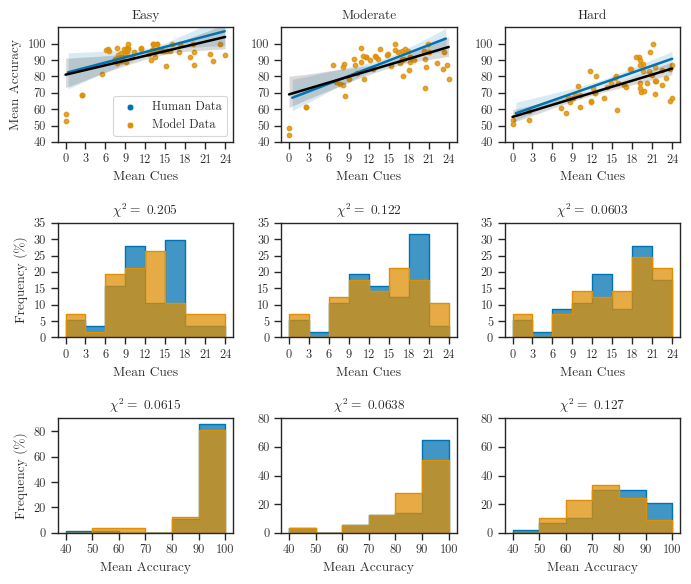

In [103]:
name = "T_m_tau_delta"
params = {0: {'delta': 0.54, 'm': 0.12, 'seed': 18, 'T': 0.9500000000000001, 'tau': 0.03}, 1: {'delta': 0.97, 'm': 0.24, 'seed': 15, 'T': 0.65, 'tau': 0.04}, 2: {'delta': 0.03, 'm': 0.42, 'seed': 87, 'T': 0.9500000000000001, 'tau': 0.11}, 3: {'delta': 0.06, 'm': 0.04, 'seed': 25, 'T': 0.96, 'tau': 0.07}, 4: {'delta': 0.66, 'm': 0.26, 'seed': 79, 'T': 0.9, 'tau': 0.02}, 5: {'delta': 0.6900000000000001, 'm': 0.44, 'seed': 88, 'T': 0.91, 'tau': 0.06}, 6: {'delta': 0.41000000000000003, 'm': 0.27, 'seed': 33, 'T': 0.76, 'tau': 0.02}, 7: {'delta': 0.91, 'm': 0.98, 'seed': 71, 'T': 0.27, 'tau': 0.74}, 8: {'delta': 0.04, 'm': 0.47000000000000003, 'seed': 25, 'T': 0.9400000000000001, 'tau': 0.05}, 9: {'delta': 0.25, 'm': 0.18, 'seed': 17, 'T': 0.99, 'tau': 0.05}, 10: {'delta': 0.29, 'm': 0.33, 'seed': 57, 'T': 0.9500000000000001, 'tau': 0.07}, 11: {'delta': 0.08, 'm': 0.72, 'seed': 14, 'T': 0.96, 'tau': 0.07}, 12: {'delta': 0.72, 'm': 0.16, 'seed': 50, 'T': 0.89, 'tau': 0.05}, 13: {'delta': 0.48, 'm': 0.27, 'seed': 12, 'T': 0.1, 'tau': 0.98}, 14: {'delta': 0.19, 'm': 0.08, 'seed': 47, 'T': 0.73, 'tau': 0.06}, 15: {'delta': 0.15, 'm': 0.1, 'seed': 43, 'T': 0.48, 'tau': 0.0}, 16: {'delta': 0.18, 'm': 0.05, 'seed': 49, 'T': 0.63, 'tau': 0.05}, 17: {'delta': 0.42, 'm': 0.66, 'seed': 43, 'T': 0.92, 'tau': 0.02}, 18: {'delta': 0.96, 'm': 0.3, 'seed': 64, 'T': 0.9500000000000001, 'tau': 0.08}, 19: {'delta': 0.9, 'm': 0.18, 'seed': 49, 'T': 0.66, 'tau': 0.0}, 20: {'delta': 0.47000000000000003, 'm': 0.12, 'seed': 31, 'T': 0.97, 'tau': 0.08}, 21: {'delta': 0.6, 'm': 0.36, 'seed': 63, 'T': 0.7000000000000001, 'tau': 0.06}, 22: {'delta': 0.52, 'm': 0.19, 'seed': 49, 'T': 0.88, 'tau': 0.1}, 23: {'delta': 0.56, 'm': 0.15, 'seed': 2, 'T': 0.71, 'tau': 0.05}, 24: {'delta': 0.5, 'm': 0.11, 'seed': 92, 'T': 0.97, 'tau': 0.07}, 25: {'delta': 0.67, 'm': 0.42, 'seed': 67, 'T': 0.88, 'tau': 0.44}, 26: {'delta': 0.8200000000000001, 'm': 0.64, 'seed': 21, 'T': 0.67, 'tau': 0.18}, 27: {'delta': 0.9, 'm': 0.07, 'seed': 65, 'T': 0.98, 'tau': 0.07}, 28: {'delta': 0.9400000000000001, 'm': 0.15, 'seed': 55, 'T': 0.89, 'tau': 0.04}, 29: {'delta': 0.72, 'm': 0.08, 'seed': 70, 'T': 0.84, 'tau': 0.03}, 30: {'delta': 0.43, 'm': 0.05, 'seed': 54, 'T': 0.98, 'tau': 0.08}, 31: {'delta': 0.65, 'm': 0.05, 'seed': 22, 'T': 1.0, 'tau': 0.08}, 32: {'delta': 0.53, 'm': 0.59, 'seed': 56, 'T': 0.98, 'tau': 0.02}, 33: {'delta': 0.43, 'm': 0.27, 'seed': 99, 'T': 0.9, 'tau': 0.1}, 34: {'delta': 0.08, 'm': 0.25, 'seed': 43, 'T': 0.89, 'tau': 0.05}, 35: {'delta': 0.52, 'm': 0.23, 'seed': 59, 'T': 0.87, 'tau': 0.0}, 36: {'delta': 0.63, 'm': 0.16, 'seed': 53, 'T': 0.85, 'tau': 0.06}, 37: {'delta': 0.8200000000000001, 'm': 0.13, 'seed': 45, 'T': 0.93, 'tau': 0.03}, 38: {'delta': 0.5700000000000001, 'm': 0.22, 'seed': 30, 'T': 0.7000000000000001, 'tau': 0.04}, 39: {'delta': 0.35000000000000003, 'm': 0.36, 'seed': 54, 'T': 0.8200000000000001, 'tau': 0.02}, 40: {'delta': 0.3, 'm': 0.37, 'seed': 23, 'T': 0.9500000000000001, 'tau': 0.0}, 41: {'delta': 0.21, 'm': 0.25, 'seed': 99, 'T': 0.5, 'tau': 0.02}, 42: {'delta': 0.38, 'm': 0.2, 'seed': 73, 'T': 0.98, 'tau': 0.05}, 43: {'delta': 0.14, 'm': 0.17, 'seed': 44, 'T': 0.81, 'tau': 0.05}, 44: {'delta': 0.52, 'm': 0.16, 'seed': 5, 'T': 0.9500000000000001, 'tau': 0.05}, 45: {'delta': 0.97, 'm': 0.27, 'seed': 37, 'T': 0.96, 'tau': 0.06}, 46: {'delta': 0.1, 'm': 0.4, 'seed': 11, 'T': 0.88, 'tau': 0.06}, 47: {'delta': 0.05, 'm': 0.2, 'seed': 93, 'T': 0.98, 'tau': 0.07}, 48: {'delta': 0.9400000000000001, 'm': 0.09, 'seed': 10, 'T': 0.86, 'tau': 0.06}, 49: {'delta': 0.08, 'm': 0.35000000000000003, 'seed': 36, 'T': 0.98, 'tau': 0.02}, 50: {'delta': 0.16, 'm': 0.16, 'seed': 77, 'T': 0.71, 'tau': 0.04}, 51: {'delta': 0.56, 'm': 0.33, 'seed': 25, 'T': 0.89, 'tau': 0.02}, 52: {'delta': 0.48, 'm': 0.5, 'seed': 85, 'T': 0.73, 'tau': 0.02}, 53: {'delta': 0.13, 'm': 0.34, 'seed': 38, 'T': 0.61, 'tau': 0.02}, 54: {'delta': 0.11, 'm': 0.02, 'seed': 78, 'T': 0.97, 'tau': 0.02}, 55: {'delta': 0.05, 'm': 0.34, 'seed': 68, 'T': 0.9400000000000001, 'tau': 0.08}, 56: {'delta': 0.05, 'm': 0.27, 'seed': 23, 'T': 0.99, 'tau': 0.05}}
# run_group(params, name=name)
plot_speed_and_accuracy(name)

### T, m, tau, delta

In [ ]:
params = {0: {'delta': 0.54, 'm': 0.12, 'seed': 18, 'T': 0.9500000000000001, 'tau': 0.03}, 1: {'delta': 0.97, 'm': 0.24, 'seed': 15, 'T': 0.65, 'tau': 0.04}, 2: {'delta': 0.03, 'm': 0.42, 'seed': 87, 'T': 0.9500000000000001, 'tau': 0.11}, 3: {'delta': 0.06, 'm': 0.04, 'seed': 25, 'T': 0.96, 'tau': 0.07}, 4: {'delta': 0.66, 'm': 0.26, 'seed': 79, 'T': 0.9, 'tau': 0.02}, 5: {'delta': 0.6900000000000001, 'm': 0.44, 'seed': 88, 'T': 0.91, 'tau': 0.06}, 6: {'delta': 0.41000000000000003, 'm': 0.27, 'seed': 33, 'T': 0.76, 'tau': 0.02}, 7: {'delta': 0.91, 'm': 0.98, 'seed': 71, 'T': 0.27, 'tau': 0.74}, 8: {'delta': 0.04, 'm': 0.47000000000000003, 'seed': 25, 'T': 0.9400000000000001, 'tau': 0.05}, 9: {'delta': 0.25, 'm': 0.18, 'seed': 17, 'T': 0.99, 'tau': 0.05}, 10: {'delta': 0.29, 'm': 0.33, 'seed': 57, 'T': 0.9500000000000001, 'tau': 0.07}, 11: {'delta': 0.08, 'm': 0.72, 'seed': 14, 'T': 0.96, 'tau': 0.07}, 12: {'delta': 0.72, 'm': 0.16, 'seed': 50, 'T': 0.89, 'tau': 0.05}, 13: {'delta': 0.48, 'm': 0.27, 'seed': 12, 'T': 0.1, 'tau': 0.98}, 14: {'delta': 0.19, 'm': 0.08, 'seed': 47, 'T': 0.73, 'tau': 0.06}, 15: {'delta': 0.15, 'm': 0.1, 'seed': 43, 'T': 0.48, 'tau': 0.0}, 16: {'delta': 0.18, 'm': 0.05, 'seed': 49, 'T': 0.63, 'tau': 0.05}, 17: {'delta': 0.42, 'm': 0.66, 'seed': 43, 'T': 0.92, 'tau': 0.02}, 18: {'delta': 0.96, 'm': 0.3, 'seed': 64, 'T': 0.9500000000000001, 'tau': 0.08}, 19: {'delta': 0.9, 'm': 0.18, 'seed': 49, 'T': 0.66, 'tau': 0.0}, 20: {'delta': 0.47000000000000003, 'm': 0.12, 'seed': 31, 'T': 0.97, 'tau': 0.08}, 21: {'delta': 0.6, 'm': 0.36, 'seed': 63, 'T': 0.7000000000000001, 'tau': 0.06}, 22: {'delta': 0.52, 'm': 0.19, 'seed': 49, 'T': 0.88, 'tau': 0.1}, 23: {'delta': 0.56, 'm': 0.15, 'seed': 2, 'T': 0.71, 'tau': 0.05}, 24: {'delta': 0.5, 'm': 0.11, 'seed': 92, 'T': 0.97, 'tau': 0.07}, 25: {'delta': 0.67, 'm': 0.42, 'seed': 67, 'T': 0.88, 'tau': 0.44}, 26: {'delta': 0.8200000000000001, 'm': 0.64, 'seed': 21, 'T': 0.67, 'tau': 0.18}, 27: {'delta': 0.9, 'm': 0.07, 'seed': 65, 'T': 0.98, 'tau': 0.07}, 28: {'delta': 0.9400000000000001, 'm': 0.15, 'seed': 55, 'T': 0.89, 'tau': 0.04}, 29: {'delta': 0.72, 'm': 0.08, 'seed': 70, 'T': 0.84, 'tau': 0.03}, 30: {'delta': 0.43, 'm': 0.05, 'seed': 54, 'T': 0.98, 'tau': 0.08}, 31: {'delta': 0.65, 'm': 0.05, 'seed': 22, 'T': 1.0, 'tau': 0.08}, 32: {'delta': 0.53, 'm': 0.59, 'seed': 56, 'T': 0.98, 'tau': 0.02}, 33: {'delta': 0.43, 'm': 0.27, 'seed': 99, 'T': 0.9, 'tau': 0.1}, 34: {'delta': 0.08, 'm': 0.25, 'seed': 43, 'T': 0.89, 'tau': 0.05}, 35: {'delta': 0.52, 'm': 0.23, 'seed': 59, 'T': 0.87, 'tau': 0.0}, 36: {'delta': 0.63, 'm': 0.16, 'seed': 53, 'T': 0.85, 'tau': 0.06}, 37: {'delta': 0.8200000000000001, 'm': 0.13, 'seed': 45, 'T': 0.93, 'tau': 0.03}, 38: {'delta': 0.5700000000000001, 'm': 0.22, 'seed': 30, 'T': 0.7000000000000001, 'tau': 0.04}, 39: {'delta': 0.35000000000000003, 'm': 0.36, 'seed': 54, 'T': 0.8200000000000001, 'tau': 0.02}, 40: {'delta': 0.3, 'm': 0.37, 'seed': 23, 'T': 0.9500000000000001, 'tau': 0.0}, 41: {'delta': 0.21, 'm': 0.25, 'seed': 99, 'T': 0.5, 'tau': 0.02}, 42: {'delta': 0.38, 'm': 0.2, 'seed': 73, 'T': 0.98, 'tau': 0.05}, 43: {'delta': 0.14, 'm': 0.17, 'seed': 44, 'T': 0.81, 'tau': 0.05}, 44: {'delta': 0.52, 'm': 0.16, 'seed': 5, 'T': 0.9500000000000001, 'tau': 0.05}, 45: {'delta': 0.97, 'm': 0.27, 'seed': 37, 'T': 0.96, 'tau': 0.06}, 46: {'delta': 0.1, 'm': 0.4, 'seed': 11, 'T': 0.88, 'tau': 0.06}, 47: {'delta': 0.05, 'm': 0.2, 'seed': 93, 'T': 0.98, 'tau': 0.07}, 48: {'delta': 0.9400000000000001, 'm': 0.09, 'seed': 10, 'T': 0.86, 'tau': 0.06}, 49: {'delta': 0.08, 'm': 0.35000000000000003, 'seed': 36, 'T': 0.98, 'tau': 0.02}, 50: {'delta': 0.16, 'm': 0.16, 'seed': 77, 'T': 0.71, 'tau': 0.04}, 51: {'delta': 0.56, 'm': 0.33, 'seed': 25, 'T': 0.89, 'tau': 0.02}, 52: {'delta': 0.48, 'm': 0.5, 'seed': 85, 'T': 0.73, 'tau': 0.02}, 53: {'delta': 0.13, 'm': 0.34, 'seed': 38, 'T': 0.61, 'tau': 0.02}, 54: {'delta': 0.11, 'm': 0.02, 'seed': 78, 'T': 0.97, 'tau': 0.02}, 55: {'delta': 0.05, 'm': 0.34, 'seed': 68, 'T': 0.9400000000000001, 'tau': 0.08}, 56: {'delta': 0.05, 'm': 0.27, 'seed': 23, 'T': 0.99, 'tau': 0.05}}
run_group(params)

pid=0, dP=0.1
pid=0, dP=0.2
pid=0, dP=0.4
pid=1, dP=0.1
pid=1, dP=0.2
pid=1, dP=0.4
pid=2, dP=0.1
pid=2, dP=0.2
pid=2, dP=0.4
pid=3, dP=0.1
pid=3, dP=0.2
pid=3, dP=0.4
pid=4, dP=0.1
pid=4, dP=0.2
pid=4, dP=0.4
pid=5, dP=0.1
pid=5, dP=0.2
pid=5, dP=0.4
pid=6, dP=0.1
pid=6, dP=0.2
pid=6, dP=0.4
pid=7, dP=0.1
pid=7, dP=0.2
pid=7, dP=0.4
pid=8, dP=0.1
pid=8, dP=0.2
pid=8, dP=0.4
pid=9, dP=0.1
pid=9, dP=0.2
pid=9, dP=0.4
pid=10, dP=0.1
pid=10, dP=0.2
pid=10, dP=0.4
pid=11, dP=0.1
pid=11, dP=0.2
pid=11, dP=0.4
pid=12, dP=0.1
pid=12, dP=0.2
pid=12, dP=0.4
pid=13, dP=0.1


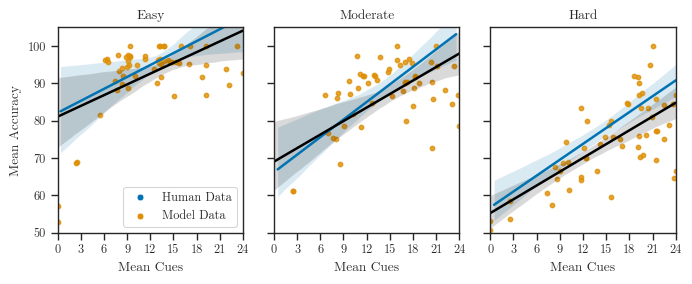

In [22]:
plot_sat_single(name="T_m_tau_delta")

In [32]:
test_sat(name="T_m_tau_delta")

easy
     Source           SS   DF          F         p-unc       np2
0     agent   152.091582    1   2.282684  1.336670e-01  0.020150
1     speed  3080.463127    1  46.233479  5.526897e-10  0.294043
2  Residual  7395.753419  111        NaN           NaN       NaN
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967076, pvalue=1.2141203747491639e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=0.9612552366606589, intercept=81.0807708791502, rvalue=0.5417597587173023, pvalue=1.3481336782803209e-05, stderr=0.20109700217968032, intercept_stderr=2.6186664935720536)
moderate
     Source           SS   DF          F         p-unc       np2
0     agent   148.606286    1   1.783133  1.844970e-01  0.015810
1     speed  6905.134450    1  82.854988  4.152650e-15  0.427407
2  Residual  9250.739692  111        NaN           NaN       NaN
human LinregressResult(slope=1.5687773565826026, intercept=66.20670

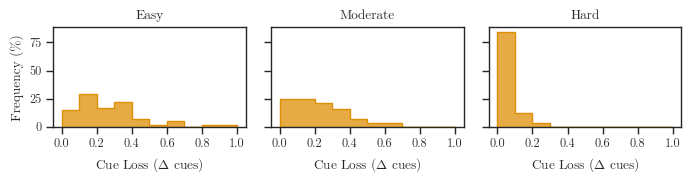

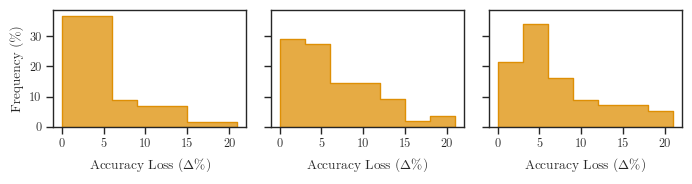

In [35]:
plot_loss(name="T_m_tau_delta")

### T, m

In [ ]:
# params = {0: {'m': 0.2, 'seed': 49, 'T': 0.79}, 1: {'m': 0.43, 'seed': 67, 'T': 0.4}, 2: {'m': 0.84, 'seed': 17, 'T': 0.8}, 3: {'m': 0.0, 'seed': 68, 'T': 0.58}, 4: {'m': 0.27, 'seed': 42, 'T': 0.51}, 5: {'m': 0.6900000000000001, 'seed': 34, 'T': 0.64}, 6: {'m': 0.97, 'seed': 16, 'T': 0.93}, 7: {'m': 0.3, 'seed': 64, 'T': 0.06}, 8: {'m': 0.4, 'seed': 73, 'T': 0.56}, 9: {'m': 0.17, 'seed': 25, 'T': 0.42}, 10: {'m': 0.05, 'seed': 91, 'T': 0.07}, 11: {'m': 0.98, 'seed': 0, 'T': 0.85}, 12: {'m': 0.26, 'seed': 1, 'T': 0.52}, 13: {'m': 0.65, 'seed': 76, 'T': 0.09}, 14: {'m': 0.28, 'seed': 77, 'T': 0.54}, 15: {'m': 0.11, 'seed': 0, 'T': 0.42}, 16: {'m': 0.12, 'seed': 22, 'T': 0.27}, 17: {'m': 0.25, 'seed': 2, 'T': 0.24}, 18: {'m': 0.19, 'seed': 97, 'T': 0.18}, 19: {'m': 0.3, 'seed': 32, 'T': 0.56}, 20: {'m': 0.37, 'seed': 54, 'T': 0.73}, 21: {'m': 0.31, 'seed': 43, 'T': 0.28}, 22: {'m': 0.58, 'seed': 88, 'T': 0.5700000000000001}, 23: {'m': 0.14, 'seed': 65, 'T': 0.26}, 24: {'m': 0.16, 'seed': 17, 'T': 0.33}, 25: {'m': 0.15, 'seed': 85, 'T': 0.07}, 26: {'m': 0.03, 'seed': 8, 'T': 0.02}, 27: {'m': 0.48, 'seed': 47, 'T': 0.9400000000000001}, 28: {'m': 0.25, 'seed': 29, 'T': 0.61}, 29: {'m': 0.04, 'seed': 47, 'T': 0.13}, 30: {'m': 0.43, 'seed': 13, 'T': 0.98}, 31: {'m': 0.08, 'seed': 10, 'T': 0.46}, 32: {'m': 0.56, 'seed': 72, 'T': 0.56}, 33: {'m': 0.13, 'seed': 46, 'T': 0.18}, 34: {'m': 0.38, 'seed': 94, 'T': 0.72}, 35: {'m': 0.38, 'seed': 25, 'T': 0.9500000000000001}, 36: {'m': 0.06, 'seed': 81, 'T': 0.12}, 37: {'m': 0.2, 'seed': 24, 'T': 0.6}, 38: {'m': 0.17, 'seed': 94, 'T': 0.27}, 39: {'m': 0.53, 'seed': 73, 'T': 0.62}, 40: {'m': 0.38, 'seed': 68, 'T': 0.73}, 41: {'m': 0.61, 'seed': 83, 'T': 0.6}, 42: {'m': 0.47000000000000003, 'seed': 58, 'T': 0.92}, 43: {'m': 0.17, 'seed': 53, 'T': 0.5}, 44: {'m': 0.27, 'seed': 11, 'T': 0.63}, 45: {'m': 0.34, 'seed': 43, 'T': 0.49}, 46: {'m': 0.33, 'seed': 95, 'T': 0.47000000000000003}, 47: {'m': 0.36, 'seed': 44, 'T': 0.89}, 48: {'m': 0.18, 'seed': 89, 'T': 0.41000000000000003}, 49: {'m': 0.13, 'seed': 42, 'T': 0.29}, 50: {'m': 0.51, 'seed': 58, 'T': 0.98}, 51: {'m': 0.6, 'seed': 37, 'T': 0.92}, 52: {'m': 0.29, 'seed': 53, 'T': 0.27}, 53: {'m': 0.16, 'seed': 24, 'T': 0.23}, 54: {'m': 0.09, 'seed': 21, 'T': 0.87}, 55: {'m': 0.02, 'seed': 1, 'T': 0.05}, 56: {'m': 0.54, 'seed': 93, 'T': 0.96}}
# run_group(params, name="tm")

In [37]:
params = {0: {'m': 0.16, 'seed': 31, 'T': 0.68}, 1: {'m': 0.43, 'seed': 67, 'T': 0.4}, 2: {'m': 0.87, 'seed': 61, 'T': 0.8300000000000001}, 3: {'m': 0.0, 'seed': 6, 'T': 0.65}, 4: {'m': 0.22, 'seed': 90, 'T': 0.41000000000000003}, 5: {'m': 0.47000000000000003, 'seed': 86, 'T': 0.44}, 6: {'m': 0.97, 'seed': 16, 'T': 0.93}, 7: {'m': 0.53, 'seed': 67, 'T': 0.02}, 8: {'m': 0.35000000000000003, 'seed': 32, 'T': 0.51}, 9: {'m': 0.15, 'seed': 43, 'T': 0.42}, 10: {'m': 0.66, 'seed': 76, 'T': 0.9500000000000001}, 11: {'m': 0.9500000000000001, 'seed': 15, 'T': 0.8200000000000001}, 12: {'m': 0.26, 'seed': 1, 'T': 0.52}, 13: {'m': 0.33, 'seed': 40, 'T': 0.13}, 14: {'m': 0.27, 'seed': 31, 'T': 0.51}, 15: {'m': 0.13, 'seed': 76, 'T': 0.51}, 16: {'m': 0.12, 'seed': 22, 'T': 0.27}, 17: {'m': 0.25, 'seed': 2, 'T': 0.24}, 18: {'m': 0.13, 'seed': 14, 'T': 0.13}, 19: {'m': 0.31, 'seed': 48, 'T': 0.58}, 20: {'m': 0.37, 'seed': 54, 'T': 0.73}, 21: {'m': 0.31, 'seed': 43, 'T': 0.28}, 22: {'m': 0.58, 'seed': 88, 'T': 0.5700000000000001}, 23: {'m': 0.14, 'seed': 65, 'T': 0.26}, 24: {'m': 0.16, 'seed': 17, 'T': 0.33}, 25: {'m': 0.15, 'seed': 85, 'T': 0.07}, 26: {'m': 0.03, 'seed': 8, 'T': 0.02}, 27: {'m': 0.48, 'seed': 47, 'T': 0.9400000000000001}, 28: {'m': 0.25, 'seed': 29, 'T': 0.61}, 29: {'m': 0.04, 'seed': 47, 'T': 0.13}, 30: {'m': 0.5, 'seed': 1, 'T': 1.0}, 31: {'m': 0.11, 'seed': 24, 'T': 0.61}, 32: {'m': 0.59, 'seed': 72, 'T': 0.58}, 33: {'m': 0.13, 'seed': 46, 'T': 0.18}, 34: {'m': 0.31, 'seed': 43, 'T': 0.6}, 35: {'m': 0.39, 'seed': 25, 'T': 0.96}, 36: {'m': 0.05, 'seed': 45, 'T': 0.08}, 37: {'m': 0.22, 'seed': 58, 'T': 0.72}, 38: {'m': 0.07, 'seed': 52, 'T': 0.12}, 39: {'m': 0.53, 'seed': 73, 'T': 0.62}, 40: {'m': 0.36, 'seed': 68, 'T': 0.7000000000000001}, 41: {'m': 0.62, 'seed': 11, 'T': 0.6}, 42: {'m': 0.47000000000000003, 'seed': 98, 'T': 0.9400000000000001}, 43: {'m': 0.25, 'seed': 84, 'T': 0.61}, 44: {'m': 0.27, 'seed': 11, 'T': 0.63}, 45: {'m': 0.34, 'seed': 43, 'T': 0.49}, 46: {'m': 0.33, 'seed': 95, 'T': 0.47000000000000003}, 47: {'m': 0.35000000000000003, 'seed': 13, 'T': 0.84}, 48: {'m': 0.19, 'seed': 2, 'T': 0.44}, 49: {'m': 0.13, 'seed': 42, 'T': 0.29}, 50: {'m': 0.51, 'seed': 58, 'T': 0.98}, 51: {'m': 0.6, 'seed': 37, 'T': 0.92}, 52: {'m': 0.29, 'seed': 53, 'T': 0.27}, 53: {'m': 0.16, 'seed': 12, 'T': 0.23}, 54: {'m': 0.1, 'seed': 52, 'T': 0.29}, 55: {'m': 0.02, 'seed': 33, 'T': 0.04}, 56: {'m': 0.54, 'seed': 10, 'T': 0.98}}
run_group(params, name="tm2")

pid=0, dP=0.1
pid=0, dP=0.2
pid=0, dP=0.4
pid=1, dP=0.1
pid=1, dP=0.2
pid=1, dP=0.4
pid=2, dP=0.1
pid=2, dP=0.2
pid=2, dP=0.4
pid=3, dP=0.1
pid=3, dP=0.2
pid=3, dP=0.4
pid=4, dP=0.1
pid=4, dP=0.2
pid=4, dP=0.4
pid=5, dP=0.1
pid=5, dP=0.2
pid=5, dP=0.4
pid=6, dP=0.1
pid=6, dP=0.2
pid=6, dP=0.4
pid=7, dP=0.1
pid=7, dP=0.2
pid=7, dP=0.4
pid=8, dP=0.1
pid=8, dP=0.2
pid=8, dP=0.4
pid=9, dP=0.1
pid=9, dP=0.2
pid=9, dP=0.4
pid=10, dP=0.1
pid=10, dP=0.2
pid=10, dP=0.4
pid=11, dP=0.1
pid=11, dP=0.2
pid=11, dP=0.4
pid=12, dP=0.1
pid=12, dP=0.2
pid=12, dP=0.4
pid=13, dP=0.1
pid=13, dP=0.2
pid=13, dP=0.4
pid=14, dP=0.1
pid=14, dP=0.2
pid=14, dP=0.4
pid=15, dP=0.1
pid=15, dP=0.2
pid=15, dP=0.4
pid=16, dP=0.1
pid=16, dP=0.2
pid=16, dP=0.4
pid=17, dP=0.1
pid=17, dP=0.2
pid=17, dP=0.4
pid=18, dP=0.1
pid=18, dP=0.2
pid=18, dP=0.4
pid=19, dP=0.1
pid=19, dP=0.2
pid=19, dP=0.4
pid=20, dP=0.1
pid=20, dP=0.2
pid=20, dP=0.4
pid=21, dP=0.1
pid=21, dP=0.2
pid=21, dP=0.4
pid=22, dP=0.1
pid=22, dP=0.2
pid=22, dP

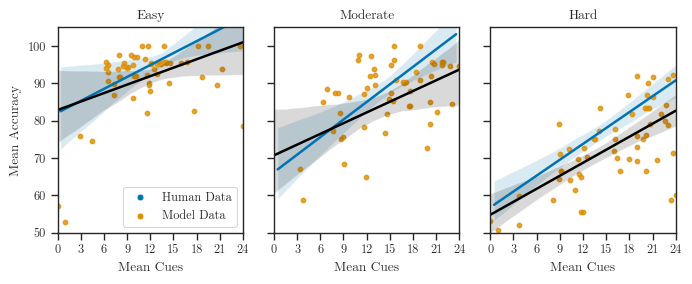

In [35]:
plot_sat_single(name="Tm2")

In [36]:
test_sat(name="Tm2")

easy
     Source           SS   DF          F         p-unc       np2
0     agent   242.723166    1   3.555632  6.195793e-02  0.031038
1     speed  2341.868720    1  34.305845  4.884367e-08  0.236094
2  Residual  7577.350930  111        NaN           NaN       NaN
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967076, pvalue=1.2141203747491639e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=0.75626812065324, intercept=82.86751325793087, rvalue=0.4230204087302963, pvalue=0.001044114150526254, stderr=0.2184333360716496, intercept_stderr=2.7316872355861306)
moderate
     Source            SS   DF          F         p-unc       np2
0     agent    508.833732    1   4.261376  4.131914e-02  0.036971
1     speed   5625.829610    1  47.115148  4.026906e-10  0.297980
2  Residual  13254.062011  111        NaN           NaN       NaN
human LinregressResult(slope=1.5687773565826026, intercept=66.20670

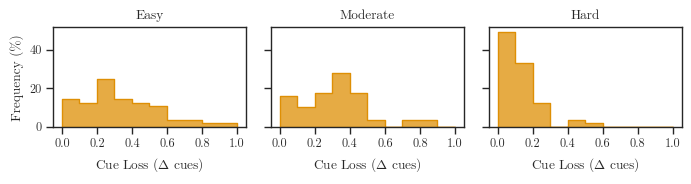

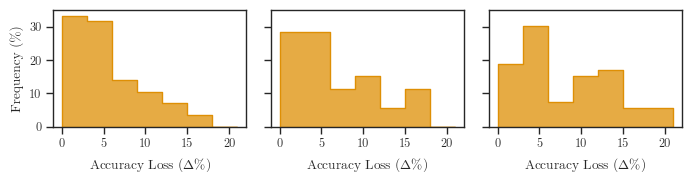

In [40]:
plot_loss(name="Tm2")

### T, m, tau

In [4]:
params = {0: {'m': 0.1, 'seed': 88, 'T': 0.66, 'tau': 0.03}, 1: {'m': 0.52, 'seed': 92, 'T': 0.85, 'tau': 0.07}, 2: {'m': 0.2, 'seed': 41, 'T': 0.39, 'tau': 0.04}, 3: {'m': 0.11, 'seed': 92, 'T': 0.88, 'tau': 0.04}, 4: {'m': 0.41000000000000003, 'seed': 6, 'T': 0.9400000000000001, 'tau': 0.05}, 5: {'m': 0.67, 'seed': 96, 'T': 1.0, 'tau': 0.11}, 6: {'m': 0.39, 'seed': 93, 'T': 0.89, 'tau': 0.05}, 7: {'m': 0.34, 'seed': 22, 'T': 0.5, 'tau': 0.8300000000000001}, 8: {'m': 0.47000000000000003, 'seed': 6, 'T': 0.88, 'tau': 0.05}, 9: {'m': 0.23, 'seed': 92, 'T': 1.0, 'tau': 0.06}, 10: {'m': 0.34, 'seed': 25, 'T': 0.8200000000000001, 'tau': 0.07}, 11: {'m': 0.73, 'seed': 3, 'T': 0.93, 'tau': 0.07}, 12: {'m': 0.23, 'seed': 22, 'T': 0.92, 'tau': 0.06}, 13: {'m': 0.5700000000000001, 'seed': 99, 'T': 0.05, 'tau': 0.38}, 14: {'m': 0.09, 'seed': 3, 'T': 0.8300000000000001, 'tau': 0.07}, 15: {'m': 0.08, 'seed': 23, 'T': 0.47000000000000003, 'tau': 0.02}, 16: {'m': 0.08, 'seed': 54, 'T': 0.96, 'tau': 0.08}, 17: {'m': 0.65, 'seed': 11, 'T': 0.73, 'tau': 0.04}, 18: {'m': 0.34, 'seed': 11, 'T': 0.93, 'tau': 0.1}, 19: {'m': 0.38, 'seed': 85, 'T': 0.72, 'tau': 0.0}, 20: {'m': 0.16, 'seed': 82, 'T': 0.86, 'tau': 0.07}, 21: {'m': 0.61, 'seed': 40, 'T': 0.88, 'tau': 0.1}, 22: {'m': 0.26, 'seed': 27, 'T': 0.71, 'tau': 0.08}, 23: {'m': 0.25, 'seed': 41, 'T': 0.86, 'tau': 0.07}, 24: {'m': 0.11, 'seed': 85, 'T': 0.72, 'tau': 0.06}, 25: {'m': 0.1, 'seed': 13, 'T': 0.63, 'tau': 0.42}, 26: {'m': 0.9, 'seed': 80, 'T': 0.8200000000000001, 'tau': 0.16}, 27: {'m': 0.16, 'seed': 74, 'T': 0.9500000000000001, 'tau': 0.06}, 28: {'m': 0.31, 'seed': 78, 'T': 0.8, 'tau': 0.01}, 29: {'m': 0.09, 'seed': 82, 'T': 0.87, 'tau': 0.06}, 30: {'m': 0.37, 'seed': 42, 'T': 0.98, 'tau': 0.05}, 31: {'m': 0.05, 'seed': 14, 'T': 0.93, 'tau': 0.08}, 32: {'m': 0.27, 'seed': 34, 'T': 0.56, 'tau': 0.03}, 33: {'m': 0.39, 'seed': 53, 'T': 0.92, 'tau': 0.1}, 34: {'m': 0.29, 'seed': 87, 'T': 0.99, 'tau': 0.06}, 35: {'m': 0.23, 'seed': 8, 'T': 0.7000000000000001, 'tau': 0.02}, 36: {'m': 0.29, 'seed': 85, 'T': 0.88, 'tau': 0.06}, 37: {'m': 0.2, 'seed': 45, 'T': 0.8, 'tau': 0.02}, 38: {'m': 0.25, 'seed': 53, 'T': 0.85, 'tau': 0.06}, 39: {'m': 0.46, 'seed': 5, 'T': 0.73, 'tau': 0.02}, 40: {'m': 0.35000000000000003, 'seed': 42, 'T': 0.67, 'tau': 0.0}, 41: {'m': 0.49, 'seed': 74, 'T': 1.0, 'tau': 0.07}, 42: {'m': 0.24, 'seed': 59, 'T': 0.84, 'tau': 0.04}, 43: {'m': 0.19, 'seed': 6, 'T': 0.88, 'tau': 0.06}, 44: {'m': 0.3, 'seed': 16, 'T': 0.85, 'tau': 0.02}, 45: {'m': 0.38, 'seed': 92, 'T': 0.87, 'tau': 0.08}, 46: {'m': 0.47000000000000003, 'seed': 69, 'T': 0.96, 'tau': 0.07}, 47: {'m': 0.2, 'seed': 27, 'T': 1.0, 'tau': 0.08}, 48: {'m': 0.16, 'seed': 83, 'T': 0.9400000000000001, 'tau': 0.07}, 49: {'m': 0.28, 'seed': 23, 'T': 0.73, 'tau': 0.02}, 50: {'m': 0.24, 'seed': 28, 'T': 0.93, 'tau': 0.05}, 51: {'m': 0.52, 'seed': 98, 'T': 0.9, 'tau': 0.02}, 52: {'m': 1.0, 'seed': 92, 'T': 0.91, 'tau': 0.0}, 53: {'m': 0.45, 'seed': 33, 'T': 0.98, 'tau': 0.05}, 54: {'m': 0.07, 'seed': 40, 'T': 0.73, 'tau': 0.03}, 55: {'m': 0.39, 'seed': 55, 'T': 0.98, 'tau': 0.08}, 56: {'m': 0.3, 'seed': 94, 'T': 0.98, 'tau': 0.04}}
run_group(params, name="T_m_tau")

pid=0, dP=0.1
pid=0, dP=0.2
pid=0, dP=0.4
pid=1, dP=0.1
pid=1, dP=0.2
pid=1, dP=0.4
pid=2, dP=0.1
pid=2, dP=0.2
pid=2, dP=0.4
pid=3, dP=0.1
pid=3, dP=0.2
pid=3, dP=0.4
pid=4, dP=0.1
pid=4, dP=0.2
pid=4, dP=0.4
pid=5, dP=0.1
pid=5, dP=0.2
pid=5, dP=0.4
pid=6, dP=0.1
pid=6, dP=0.2
pid=6, dP=0.4
pid=7, dP=0.1
pid=7, dP=0.2
pid=7, dP=0.4
pid=8, dP=0.1
pid=8, dP=0.2
pid=8, dP=0.4
pid=9, dP=0.1
pid=9, dP=0.2
pid=9, dP=0.4
pid=10, dP=0.1
pid=10, dP=0.2
pid=10, dP=0.4
pid=11, dP=0.1
pid=11, dP=0.2
pid=11, dP=0.4
pid=12, dP=0.1
pid=12, dP=0.2
pid=12, dP=0.4
pid=13, dP=0.1
pid=13, dP=0.2
pid=13, dP=0.4
pid=14, dP=0.1
pid=14, dP=0.2
pid=14, dP=0.4
pid=15, dP=0.1
pid=15, dP=0.2
pid=15, dP=0.4
pid=16, dP=0.1
pid=16, dP=0.2
pid=16, dP=0.4
pid=17, dP=0.1
pid=17, dP=0.2
pid=17, dP=0.4
pid=18, dP=0.1
pid=18, dP=0.2
pid=18, dP=0.4
pid=19, dP=0.1
pid=19, dP=0.2
pid=19, dP=0.4
pid=20, dP=0.1
pid=20, dP=0.2
pid=20, dP=0.4
pid=21, dP=0.1
pid=21, dP=0.2
pid=21, dP=0.4
pid=22, dP=0.1
pid=22, dP=0.2
pid=22, dP

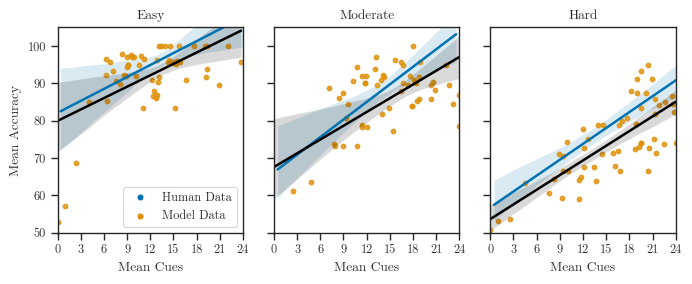

In [37]:
plot_sat_single(name="T_m_tau")

In [38]:
test_sat(name="T_m_tau")

easy
     Source           SS   DF          F         p-unc       np2
0     agent   215.014031    1   3.410017  6.746563e-02  0.029805
1     speed  3048.804007    1  48.352539  2.590301e-10  0.303431
2  Residual  6998.954941  111        NaN           NaN       NaN
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967076, pvalue=1.2141203747491639e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=1.0175690488276694, intercept=79.96683039660483, rvalue=0.5589213252814245, pvalue=6.2208799052873494e-06, stderr=0.20356447677478942, intercept_stderr=2.631240574322655)
moderate
     Source           SS   DF          F         p-unc       np2
0     agent   340.271014    1   4.344176  3.943029e-02  0.037663
1     speed  6720.699226    1  85.801909  1.780433e-15  0.435981
2  Residual  8694.417398  111        NaN           NaN       NaN
human LinregressResult(slope=1.5687773565826026, intercept=66.20670

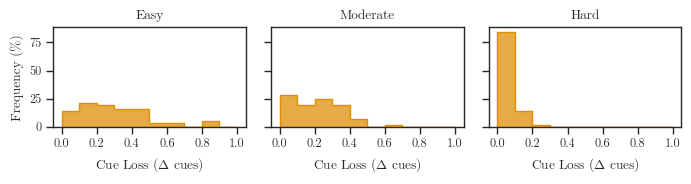

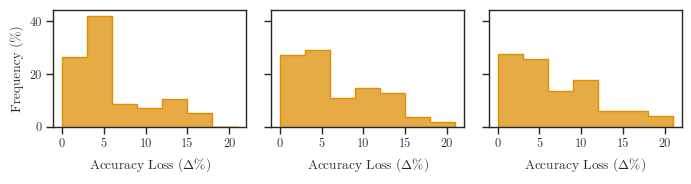

In [7]:
plot_loss(name="T_m_tau")

### T, m, delta (number 1)

In [39]:
params = {0: {'delta': 0.25, 'm': 0.16, 'seed': 11, 'T': 0.84}, 1: {'delta': 0.5, 'm': 0.33, 'seed': 5, 'T': 0.46}, 2: {'delta': 0.97, 'm': 0.2, 'seed': 88, 'T': 0.37}, 3: {'delta': 0.9, 'm': 0.02, 'seed': 88, 'T': 0.61}, 4: {'delta': 0.06, 'm': 0.2, 'seed': 80, 'T': 0.39}, 5: {'delta': 0.56, 'm': 0.04, 'seed': 70, 'T': 0.09}, 6: {'delta': 0.05, 'm': 0.96, 'seed': 92, 'T': 0.96}, 7: {'delta': 0.72, 'm': 0.84, 'seed': 32, 'T': 0.26}, 8: {'delta': 0.27, 'm': 0.35000000000000003, 'seed': 23, 'T': 0.62}, 9: {'delta': 0.38, 'm': 0.27, 'seed': 17, 'T': 0.93}, 10: {'delta': 0.8300000000000001, 'm': 0.12, 'seed': 52, 'T': 0.31}, 11: {'delta': 0.52, 'm': 0.66, 'seed': 22, 'T': 0.93}, 12: {'delta': 0.7000000000000001, 'm': 0.26, 'seed': 4, 'T': 0.89}, 13: {'delta': 0.75, 'm': 0.52, 'seed': 46, 'T': 0.39}, 14: {'delta': 0.37, 'm': 0.29, 'seed': 98, 'T': 0.77}, 15: {'delta': 0.42, 'm': 0.14, 'seed': 85, 'T': 0.9}, 16: {'delta': 0.87, 'm': 0.08, 'seed': 37, 'T': 0.41000000000000003}, 17: {'delta': 0.97, 'm': 0.38, 'seed': 76, 'T': 0.6900000000000001}, 18: {'delta': 0.99, 'm': 0.29, 'seed': 16, 'T': 0.55}, 19: {'delta': 0.35000000000000003, 'm': 0.34, 'seed': 41, 'T': 0.87}, 20: {'delta': 0.52, 'm': 0.27, 'seed': 73, 'T': 0.81}, 21: {'delta': 0.78, 'm': 0.35000000000000003, 'seed': 90, 'T': 0.56}, 22: {'delta': 0.98, 'm': 0.07, 'seed': 47, 'T': 0.23}, 23: {'delta': 0.88, 'm': 0.16, 'seed': 65, 'T': 0.54}, 24: {'delta': 0.45, 'm': 0.16, 'seed': 67, 'T': 0.44}, 25: {'delta': 0.9500000000000001, 'm': 0.59, 'seed': 65, 'T': 0.48}, 26: {'delta': 1.0, 'm': 0.96, 'seed': 47, 'T': 0.86}, 27: {'delta': 0.04, 'm': 0.49, 'seed': 87, 'T': 0.97}, 28: {'delta': 0.6, 'm': 0.2, 'seed': 17, 'T': 0.78}, 29: {'delta': 0.8300000000000001, 'm': 0.15, 'seed': 93, 'T': 0.7000000000000001}, 30: {'delta': 0.2, 'm': 0.33, 'seed': 97, 'T': 0.9}, 31: {'delta': 0.12, 'm': 0.15, 'seed': 67, 'T': 0.93}, 32: {'delta': 0.55, 'm': 0.58, 'seed': 42, 'T': 0.85}, 33: {'delta': 0.61, 'm': 0.12, 'seed': 87, 'T': 0.24}, 34: {'delta': 0.15, 'm': 0.36, 'seed': 38, 'T': 0.8}, 35: {'delta': 0.04, 'm': 0.19, 'seed': 18, 'T': 0.48}, 36: {'delta': 0.31, 'm': 0.37, 'seed': 87, 'T': 0.9400000000000001}, 37: {'delta': 0.26, 'm': 0.24, 'seed': 44, 'T': 0.91}, 38: {'delta': 0.41000000000000003, 'm': 0.08, 'seed': 52, 'T': 0.19}, 39: {'delta': 0.45, 'm': 0.46, 'seed': 55, 'T': 0.9400000000000001}, 40: {'delta': 0.04, 'm': 0.36, 'seed': 4, 'T': 0.73}, 41: {'delta': 0.66, 'm': 0.61, 'seed': 11, 'T': 0.98}, 42: {'delta': 0.8300000000000001, 'm': 0.15, 'seed': 59, 'T': 0.65}, 43: {'delta': 0.55, 'm': 0.13, 'seed': 50, 'T': 0.5700000000000001}, 44: {'delta': 0.55, 'm': 0.27, 'seed': 97, 'T': 1.0}, 45: {'delta': 0.53, 'm': 0.16, 'seed': 79, 'T': 0.33}, 46: {'delta': 0.26, 'm': 0.2, 'seed': 3, 'T': 0.34}, 47: {'delta': 0.46, 'm': 0.1, 'seed': 0, 'T': 0.41000000000000003}, 48: {'delta': 0.32, 'm': 0.22, 'seed': 84, 'T': 0.66}, 49: {'delta': 0.7000000000000001, 'm': 0.21, 'seed': 32, 'T': 0.71}, 50: {'delta': 0.56, 'm': 0.22, 'seed': 68, 'T': 0.81}, 51: {'delta': 0.96, 'm': 0.31, 'seed': 26, 'T': 0.91}, 52: {'delta': 0.5, 'm': 0.26, 'seed': 15, 'T': 0.36}, 53: {'delta': 0.85, 'm': 0.25, 'seed': 32, 'T': 0.86}, 54: {'delta': 0.1, 'm': 0.24, 'seed': 66, 'T': 0.9}, 55: {'delta': 0.23, 'm': 0.47000000000000003, 'seed': 71, 'T': 0.8200000000000001}, 56: {'delta': 0.98, 'm': 0.15, 'seed': 37, 'T': 0.53}}
run_group(params, name="T_m_delta")

pid=0, dP=0.1
pid=0, dP=0.2
pid=0, dP=0.4
pid=1, dP=0.1
pid=1, dP=0.2
pid=1, dP=0.4
pid=2, dP=0.1
pid=2, dP=0.2
pid=2, dP=0.4
pid=3, dP=0.1
pid=3, dP=0.2
pid=3, dP=0.4
pid=4, dP=0.1
pid=4, dP=0.2
pid=4, dP=0.4
pid=5, dP=0.1
pid=5, dP=0.2
pid=5, dP=0.4
pid=6, dP=0.1
pid=6, dP=0.2
pid=6, dP=0.4
pid=7, dP=0.1
pid=7, dP=0.2
pid=7, dP=0.4
pid=8, dP=0.1
pid=8, dP=0.2
pid=8, dP=0.4
pid=9, dP=0.1
pid=9, dP=0.2
pid=9, dP=0.4
pid=10, dP=0.1
pid=10, dP=0.2
pid=10, dP=0.4
pid=11, dP=0.1
pid=11, dP=0.2
pid=11, dP=0.4
pid=12, dP=0.1
pid=12, dP=0.2
pid=12, dP=0.4
pid=13, dP=0.1
pid=13, dP=0.2
pid=13, dP=0.4
pid=14, dP=0.1
pid=14, dP=0.2
pid=14, dP=0.4
pid=15, dP=0.1
pid=15, dP=0.2
pid=15, dP=0.4
pid=16, dP=0.1
pid=16, dP=0.2
pid=16, dP=0.4
pid=17, dP=0.1
pid=17, dP=0.2
pid=17, dP=0.4
pid=18, dP=0.1
pid=18, dP=0.2
pid=18, dP=0.4
pid=19, dP=0.1
pid=19, dP=0.2
pid=19, dP=0.4
pid=20, dP=0.1
pid=20, dP=0.2
pid=20, dP=0.4
pid=21, dP=0.1
pid=21, dP=0.2
pid=21, dP=0.4
pid=22, dP=0.1
pid=22, dP=0.2
pid=22, dP

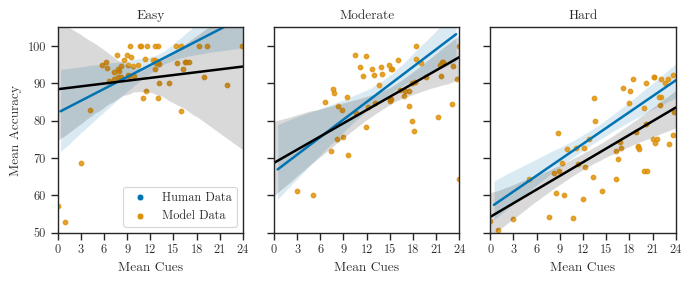

In [4]:
plot_sat_single(name="T_m_delta")

In [5]:
test_sat(name="T_m_delta")

easy
     Source            SS   DF         F     p-unc       np2
0     agent    309.239431    1  2.496634  0.116935  0.021997
1     speed   1228.233425    1  9.916100  0.002105  0.082008
2  Residual  13748.742882  111       NaN       NaN       NaN
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967076, pvalue=1.2141203747491639e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=0.2534023884878888, intercept=88.44269741005981, rvalue=0.09745903624858285, pvalue=0.47077550858113115, stderr=0.3489272337991386, intercept_stderr=4.368208208275371)
moderate
     Source           SS   DF          F         p-unc       np2
0     agent   262.057444    1   2.939726  8.921615e-02  0.025801
1     speed  6725.558961    1  75.446434  3.706358e-14  0.404655
2  Residual  9894.928119  111        NaN           NaN       NaN
human LinregressResult(slope=1.5687773565826026, intercept=66.20670768575947, rvalue=0

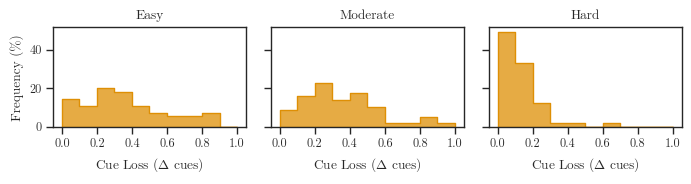

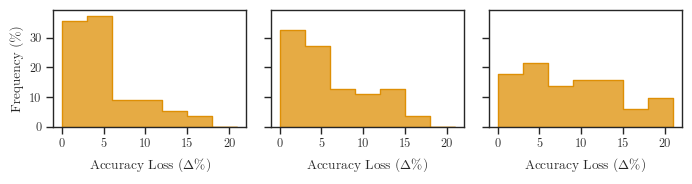

In [6]:
plot_loss(name="T_m_delta")

In [7]:
params = {0: {'delta': 0.01, 'm': 0.18, 'seed': 68, 'T': 0.75}, 1: {'delta': 0.09, 'm': 0.8300000000000001, 'seed': 6, 'T': 0.86}, 2: {'delta': 0.09, 'm': 0.17, 'seed': 29, 'T': 0.18}, 3: {'delta': 0.17, 'm': 0.0, 'seed': 48, 'T': 0.98}, 4: {'delta': 0.11, 'm': 0.24, 'seed': 77, 'T': 0.5}, 5: {'delta': 0.16, 'm': 0.38, 'seed': 1, 'T': 0.4}, 6: {'delta': 0.0, 'm': 0.37, 'seed': 67, 'T': 0.53}, 7: {'delta': 0.12, 'm': 0.65, 'seed': 6, 'T': 0.12}, 8: {'delta': 0.07, 'm': 0.34, 'seed': 42, 'T': 0.51}, 9: {'delta': 0.03, 'm': 0.12, 'seed': 92, 'T': 0.32}, 10: {'delta': 0.05, 'm': 0.14, 'seed': 79, 'T': 0.2}, 11: {'delta': 0.2, 'm': 0.9500000000000001, 'seed': 7, 'T': 1.0}, 12: {'delta': 0.17, 'm': 0.25, 'seed': 47, 'T': 0.67}, 13: {'delta': 0.06, 'm': 0.78, 'seed': 87, 'T': 0.3}, 14: {'delta': 0.09, 'm': 0.29, 'seed': 49, 'T': 0.59}, 15: {'delta': 0.2, 'm': 0.15, 'seed': 4, 'T': 0.7000000000000001}, 16: {'delta': 0.17, 'm': 0.2, 'seed': 51, 'T': 0.55}, 17: {'delta': 0.11, 'm': 0.4, 'seed': 80, 'T': 0.41000000000000003}, 18: {'delta': 0.13, 'm': 0.61, 'seed': 79, 'T': 0.67}, 19: {'delta': 0.18, 'm': 0.37, 'seed': 91, 'T': 0.8200000000000001}, 20: {'delta': 0.06, 'm': 0.33, 'seed': 9, 'T': 0.68}, 21: {'delta': 0.13, 'm': 0.39, 'seed': 92, 'T': 0.4}, 22: {'delta': 0.17, 'm': 0.23, 'seed': 41, 'T': 0.25}, 23: {'delta': 0.2, 'm': 0.24, 'seed': 63, 'T': 0.54}, 24: {'delta': 0.06, 'm': 0.39, 'seed': 87, 'T': 0.8200000000000001}, 25: {'delta': 0.12, 'm': 0.48, 'seed': 9, 'T': 0.23}, 26: {'delta': 0.15, 'm': 1.0, 'seed': 13, 'T': 0.51}, 27: {'delta': 0.2, 'm': 0.07, 'seed': 71, 'T': 0.22}, 28: {'delta': 0.02, 'm': 0.31, 'seed': 51, 'T': 0.76}, 29: {'delta': 0.11, 'm': 0.21, 'seed': 84, 'T': 0.59}, 30: {'delta': 0.0, 'm': 0.45, 'seed': 6, 'T': 0.96}, 31: {'delta': 0.05, 'm': 0.15, 'seed': 31, 'T': 0.96}, 32: {'delta': 0.11, 'm': 0.6, 'seed': 91, 'T': 0.65}, 33: {'delta': 0.17, 'm': 0.1, 'seed': 63, 'T': 0.12}, 34: {'delta': 0.13, 'm': 0.34, 'seed': 17, 'T': 0.73}, 35: {'delta': 0.17, 'm': 0.26, 'seed': 81, 'T': 0.78}, 36: {'delta': 0.17, 'm': 0.27, 'seed': 48, 'T': 0.58}, 37: {'delta': 0.2, 'm': 0.25, 'seed': 70, 'T': 0.9}, 38: {'delta': 0.2, 'm': 0.12, 'seed': 66, 'T': 0.22}, 39: {'delta': 0.19, 'm': 0.15, 'seed': 88, 'T': 0.25}, 40: {'delta': 0.17, 'm': 0.33, 'seed': 27, 'T': 0.74}, 41: {'delta': 0.07, 'm': 0.07, 'seed': 70, 'T': 0.1}, 42: {'delta': 0.03, 'm': 0.45, 'seed': 30, 'T': 0.97}, 43: {'delta': 0.09, 'm': 0.27, 'seed': 71, 'T': 0.71}, 44: {'delta': 0.04, 'm': 0.18, 'seed': 96, 'T': 0.44}, 45: {'delta': 0.13, 'm': 0.08, 'seed': 6, 'T': 0.14}, 46: {'delta': 0.14, 'm': 0.13, 'seed': 72, 'T': 0.2}, 47: {'delta': 0.05, 'm': 0.39, 'seed': 72, 'T': 0.98}, 48: {'delta': 0.17, 'm': 0.36, 'seed': 30, 'T': 0.8200000000000001}, 49: {'delta': 0.13, 'm': 0.22, 'seed': 32, 'T': 0.49}, 50: {'delta': 0.18, 'm': 0.18, 'seed': 14, 'T': 0.5}, 51: {'delta': 0.18, 'm': 0.34, 'seed': 62, 'T': 0.59}, 52: {'delta': 0.2, 'm': 0.61, 'seed': 50, 'T': 0.6900000000000001}, 53: {'delta': 0.04, 'm': 0.21, 'seed': 93, 'T': 0.31}, 54: {'delta': 0.15, 'm': 0.11, 'seed': 6, 'T': 0.44}, 55: {'delta': 0.08, 'm': 0.38, 'seed': 17, 'T': 0.58}, 56: {'delta': 0.16, 'm': 0.22, 'seed': 73, 'T': 0.61}}
run_group(params, name="T_m_delta2")

pid=0, dP=0.1
pid=0, dP=0.2
pid=0, dP=0.4
pid=1, dP=0.1
pid=1, dP=0.2
pid=1, dP=0.4
pid=2, dP=0.1
pid=2, dP=0.2
pid=2, dP=0.4
pid=3, dP=0.1
pid=3, dP=0.2
pid=3, dP=0.4
pid=4, dP=0.1
pid=4, dP=0.2
pid=4, dP=0.4
pid=5, dP=0.1
pid=5, dP=0.2
pid=5, dP=0.4
pid=6, dP=0.1
pid=6, dP=0.2
pid=6, dP=0.4
pid=7, dP=0.1
pid=7, dP=0.2
pid=7, dP=0.4
pid=8, dP=0.1
pid=8, dP=0.2
pid=8, dP=0.4
pid=9, dP=0.1
pid=9, dP=0.2
pid=9, dP=0.4
pid=10, dP=0.1
pid=10, dP=0.2
pid=10, dP=0.4
pid=11, dP=0.1
pid=11, dP=0.2
pid=11, dP=0.4
pid=12, dP=0.1
pid=12, dP=0.2
pid=12, dP=0.4
pid=13, dP=0.1
pid=13, dP=0.2
pid=13, dP=0.4
pid=14, dP=0.1
pid=14, dP=0.2
pid=14, dP=0.4
pid=15, dP=0.1
pid=15, dP=0.2
pid=15, dP=0.4
pid=16, dP=0.1
pid=16, dP=0.2
pid=16, dP=0.4
pid=17, dP=0.1
pid=17, dP=0.2
pid=17, dP=0.4
pid=18, dP=0.1
pid=18, dP=0.2
pid=18, dP=0.4
pid=19, dP=0.1
pid=19, dP=0.2
pid=19, dP=0.4
pid=20, dP=0.1
pid=20, dP=0.2
pid=20, dP=0.4
pid=21, dP=0.1
pid=21, dP=0.2
pid=21, dP=0.4
pid=22, dP=0.1
pid=22, dP=0.2
pid=22, dP

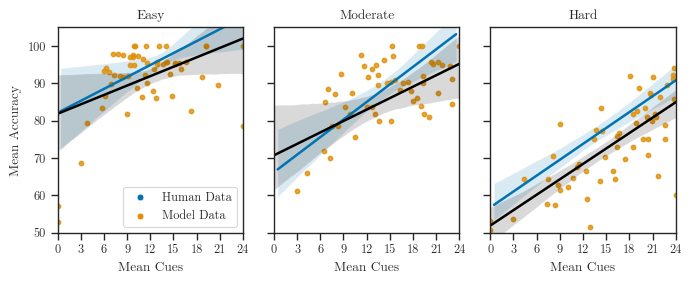

In [8]:
plot_sat_single(name="T_m_delta2")

In [9]:
test_sat(name="T_m_delta2")

easy
     Source           SS   DF          F         p-unc       np2
0     agent   243.391248    1   3.466409  6.527226e-02  0.030283
1     speed  2571.837362    1  36.628430  1.979253e-08  0.248112
2  Residual  7793.780553  111        NaN           NaN       NaN
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967076, pvalue=1.2141203747491639e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=0.8401130601309126, intercept=81.86413810092866, rvalue=0.45045518635373594, pvalue=0.0004380246091033721, stderr=0.2245217994521018, intercept_stderr=2.7974423427435444)
moderate
     Source            SS   DF          F         p-unc       np2
0     agent    303.330919    1   2.704644  1.028856e-01  0.023787
1     speed   6007.485065    1  53.565626  4.197554e-11  0.325497
2  Residual  12448.857544  111        NaN           NaN       NaN
human LinregressResult(slope=1.5687773565826026, intercept=66.2

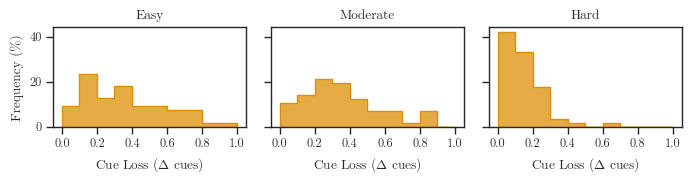

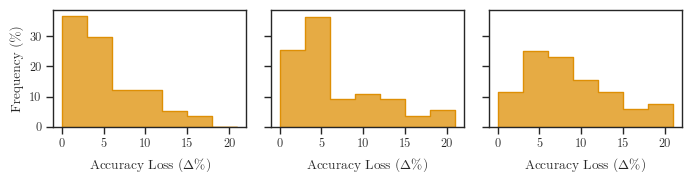

In [10]:
plot_loss(name="T_m_delta2")

## Paper Plots

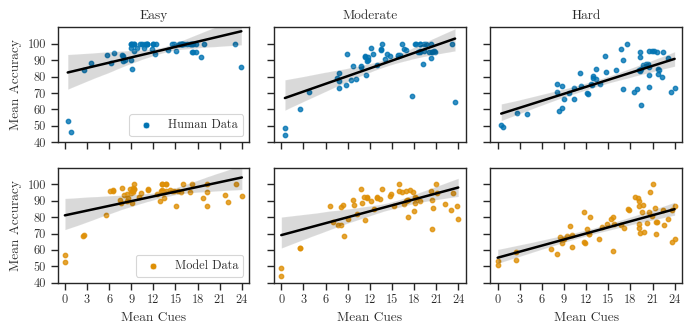

In [206]:
plot_sat_double("T_m_tau_delta")

In [201]:
print(pd.read_pickle(f"data/group_behavior_T_m_tau_delta.pkl").query("dP==0.4 & agent=='human'")['accuracy'])

5       91.666667
11      89.583333
17      93.333333
23      85.714286
29     100.000000
35      93.220339
41     100.000000
47      46.583851
53     100.000000
59     100.000000
65      90.000000
71      95.348837
77     100.000000
83      52.820513
89     100.000000
95     100.000000
101    100.000000
107     88.333333
113    100.000000
119    100.000000
125     95.833333
131     90.384615
137     97.435897
143     93.939394
149    100.000000
155     83.941606
161     88.505747
167     95.238095
173    100.000000
179    100.000000
185    100.000000
191    100.000000
197     97.368421
203     92.307692
209     96.153846
215     95.238095
221    100.000000
227    100.000000
233    100.000000
239    100.000000
245     96.551724
251     84.848485
257     95.238095
263    100.000000
269    100.000000
275     97.297297
281    100.000000
287    100.000000
293    100.000000
299    100.000000
305    100.000000
311    100.000000
317     94.444444
323    100.000000
329    100.000000
335    100